In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from mid_simulations.simulation_funcs import (
    create_contrasts,
    create_design_matrices,
    get_beta_dicts,
    get_subdata_long,
    make_analysis_label,
    sim_group_models_parallel,
)
from mid_simulations.simulation_plotting import (
    plot_bias,
    plot_bias_significance,
    plot_design_ordered_regressors,
    plot_dict_of_results,
    plot_error_grid,
    plot_results,
)


In [2]:
# Change this to the path where you want to save the output figures
figure_output_path = (
    '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures_revision'
)
# Change this to AHRB if you're using the AHRB data (distributed with this repo)
dataset = 'ABCD'

## Design matrices and contrasts

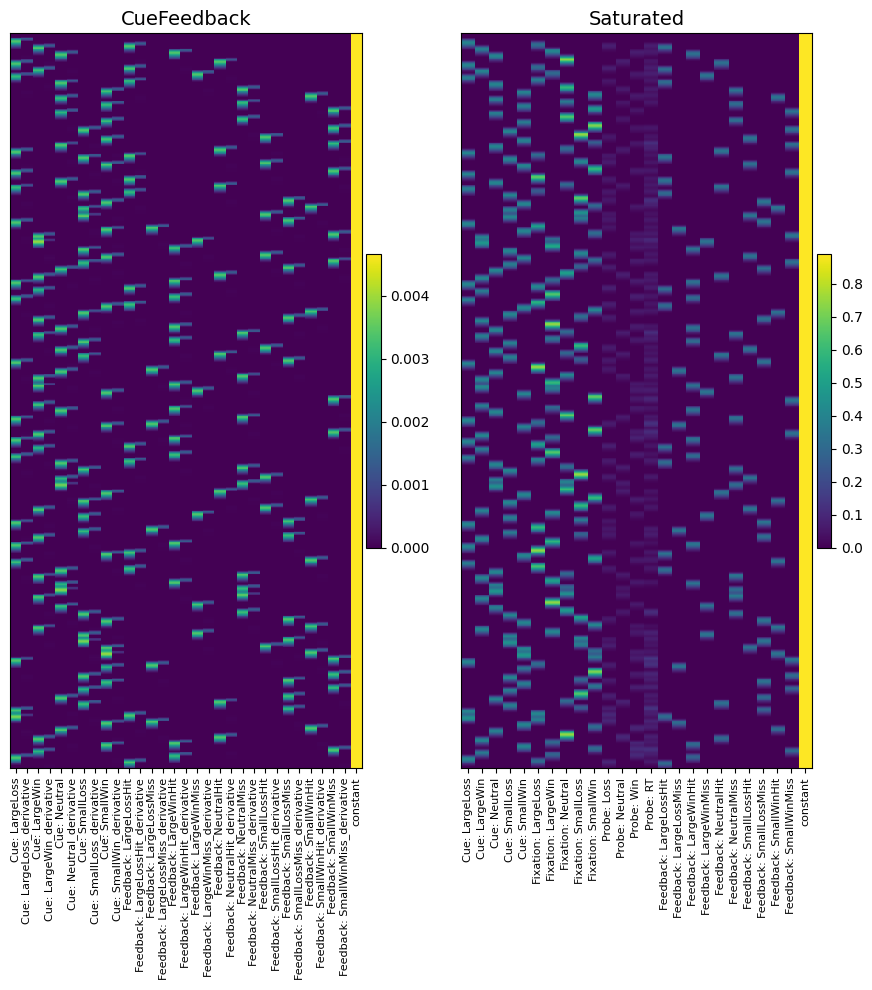

In [3]:
fig_path = f'{figure_output_path}/design_matrices.pdf'
sub = 4
events = get_subdata_long(sub, dataset=dataset)
designs = create_design_matrices(events, oversampling=50, tr=0.8)

fig, ax = plt.subplots(1, 2, figsize=(9, 10))
ax_flat = ax.flatten()
for i, desname in enumerate(['CueYesDeriv', 'Saturated']):
    plot_label = desname if desname == 'Saturated' else 'CueFeedback'
    plot_design_ordered_regressors(designs[desname], plot_label, ax=ax_flat[i])
    ax_flat[i].set_title(plot_label, fontsize=14)
    ax_flat[i].tick_params(
        axis='x',
        bottom=True,
        top=False,
        labelbottom=True,
        labeltop=False,
        rotation=90,
        labelsize=8,
    )
    ax_flat[i].tick_params(axis='y', labelsize=8)
    ax_flat[i].yaxis.set_ticks([])
    ax_flat[i].yaxis.set_ticklabels([])
    ax_flat[i].set_ylabel('')
    for label in ax_flat[i].get_xticklabels():
        label.set_horizontalalignment('center')
fig.align_titles()
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [4]:
contrast_strings, contrasts_matrices, c_pinv_xmats = create_contrasts(designs)
interesting_contrast_substr = ['-']
for key, contrasts in contrast_strings.items():
    print(f'\n Contrasts for {key} model')
    for contrast_name, contrast_string in contrasts.items():
        if any(x in contrast_name for x in interesting_contrast_substr):
            print(f'{contrast_name}: {contrast_string}')


 Contrasts for Saturated model
Cue: LW-Base: 1* Cue_LargeWin
Cue: LW-Neut*: 1 * Cue_LargeWin - 1 * Cue_Neutral
Cue: LL-Neut*: 1 * Cue_LargeLoss - 1 * Cue_Neutral
FB: LWHit-Base: 1 * Feedback_LargeWinHit
FB: LWHit-NeutHit: 1 * Feedback_LargeWinHit - 1 * Feedback_NeutralHit
FB: WHit-WMiss*: .5 * Feedback_LargeWinHit + .5 * Feedback_SmallWinHit - .5 * Feedback_LargeWinMiss - .5 * Feedback_SmallWinMiss
FB: LHit-LMiss*: .5 * Feedback_LargeLossHit + .5 * Feedback_SmallLossHit - .5 * Feedback_LargeLossMiss - .5 * Feedback_SmallLossMiss

 Contrasts for CueNoDeriv model
Cue: LW-Base: 1* Cue_LargeWin
Cue: LW-Neut*: 1 * Cue_LargeWin - 1 * Cue_Neutral
Cue: LL-Neut*: 1 * Cue_LargeLoss - 1 * Cue_Neutral
FB: LWHit-Base: 1 * Feedback_LargeWinHit
FB: LWHit-NeutHit: 1 * Feedback_LargeWinHit - 1 * Feedback_NeutralHit
FB: WHit-WMiss*: .5 * Feedback_LargeWinHit + .5 * Feedback_SmallWinHit - .5 * Feedback_LargeWinMiss - .5 * Feedback_SmallWinMiss
FB: LHit-LMiss*: .5 * Feedback_LargeLossHit + .5 * Feedback_

## Main simulations comparing ABCD to Saturated model

In [5]:
np.random.seed(8888)

beta_dicts = get_beta_dicts(dataset=dataset)

beta_sub_sd = 1.5
noise_sd = 1
nsims = 1000
results = {}

for beta_dict in beta_dicts:
    print(beta_dict)
    figure_label = make_analysis_label(beta_dict)
    results[figure_label], _, model_example = sim_group_models_parallel(
        beta_dict,
        noise_sd,
        beta_sub_sd,
        nsims=nsims,
        oversampling=50,
        tr=0.8,
        dataset=dataset,
        include_hp_filter=True,
    )

{}
{'Cue: LargeWin': 0.22, 'Cue: SmallWin': 0.22}
{'Fixation: LargeWin': 0.22, 'Fixation: SmallWin': 0.22}
{'Probe: Win': 0.85}
{'Probe: RT': 0.35}
{'Feedback: LargeWinHit': 0.25, 'Feedback: SmallWinHit': 0.25}


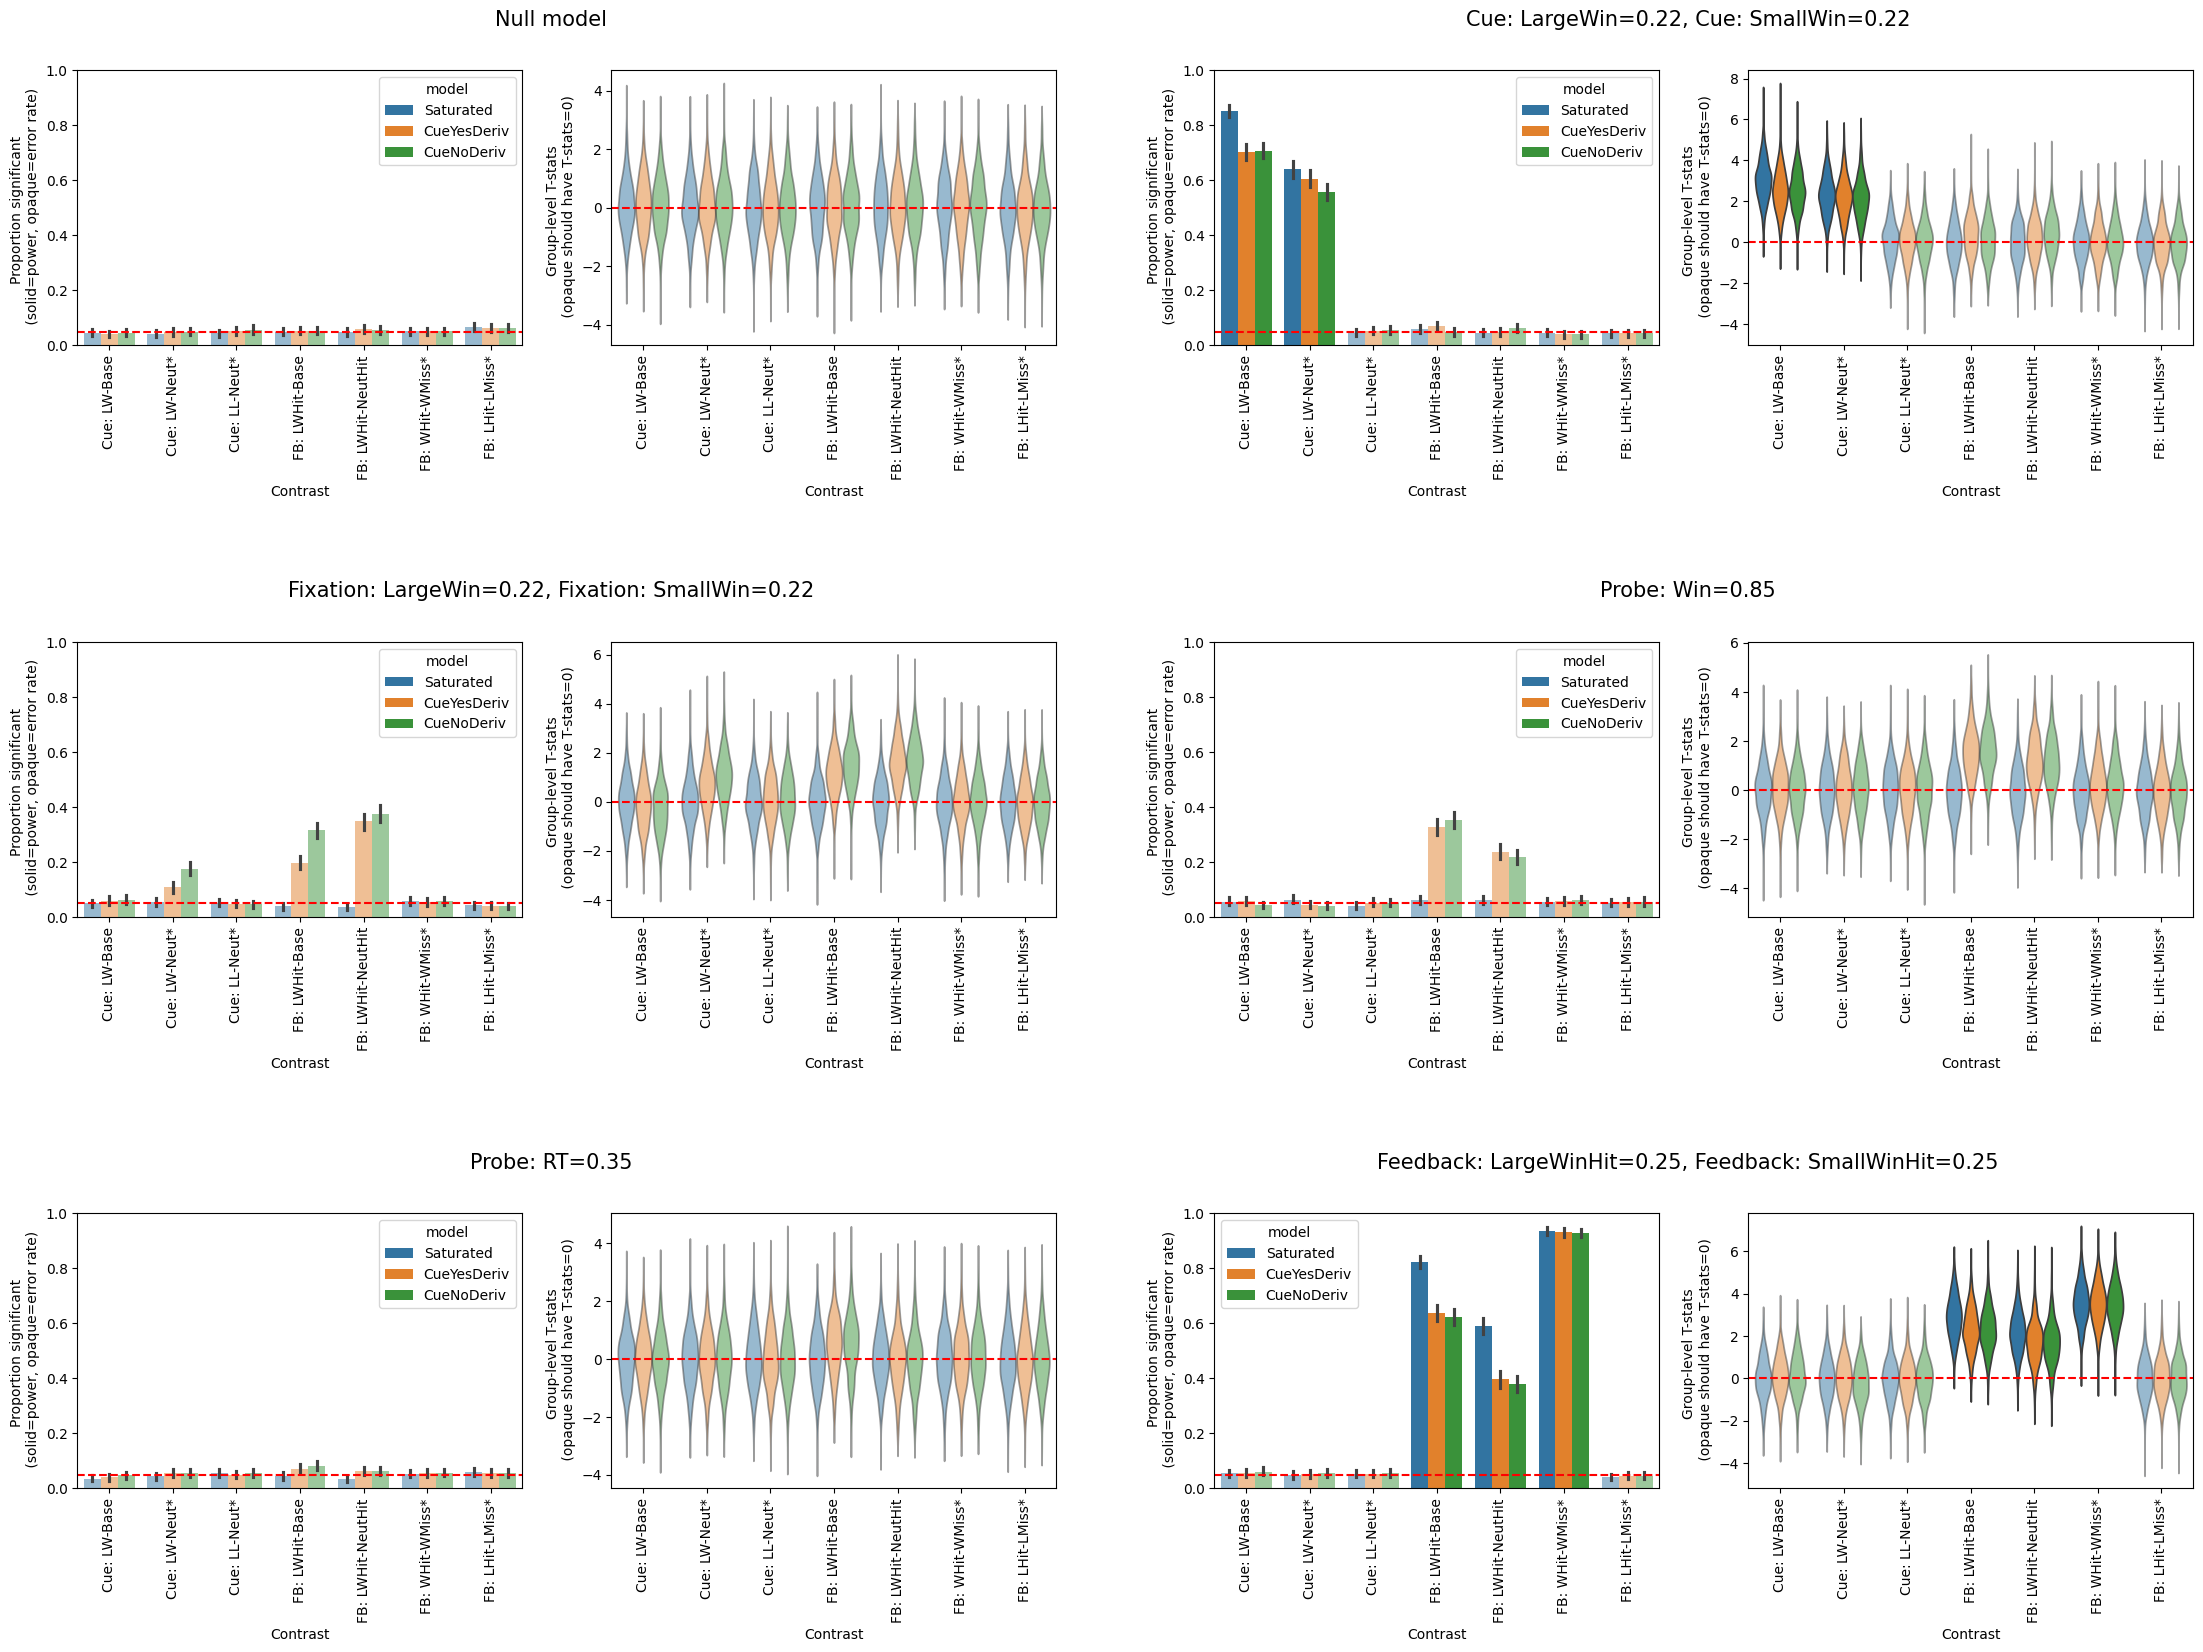

In [6]:
results_plot = results.copy()
plot_dict_of_results(results_plot, contrasts=True)

### Rejection rages and estimate distributions
Opaque bars/violins correspond to contrasts that are null, so the error rates should be at 0.05 and t-stat distributions should be centered about 0.

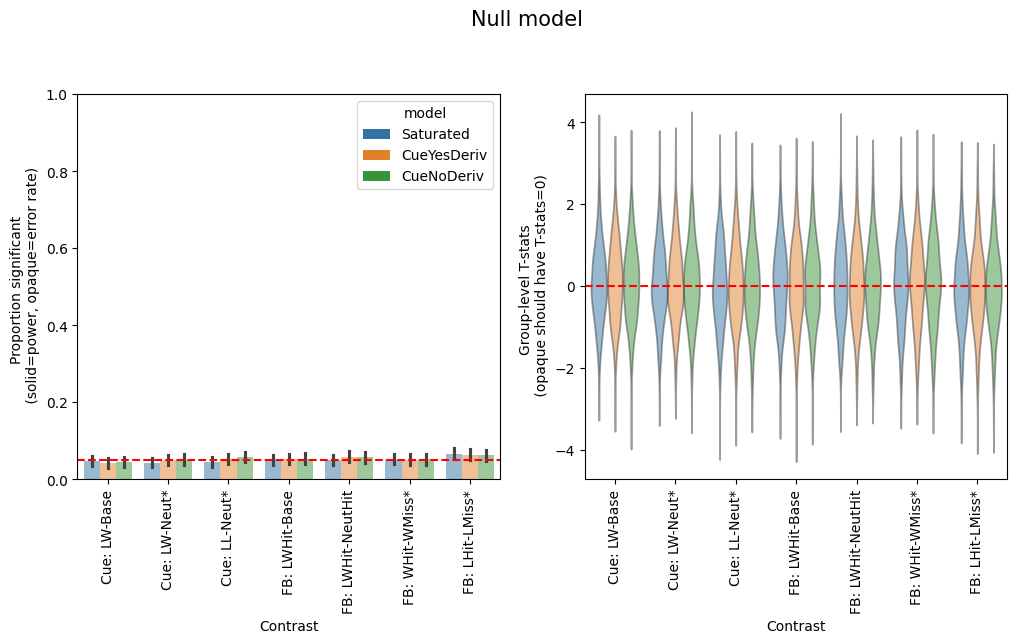

In [7]:
plot_dict_of_results({'Null model': results['Null model']}, contrasts=True)

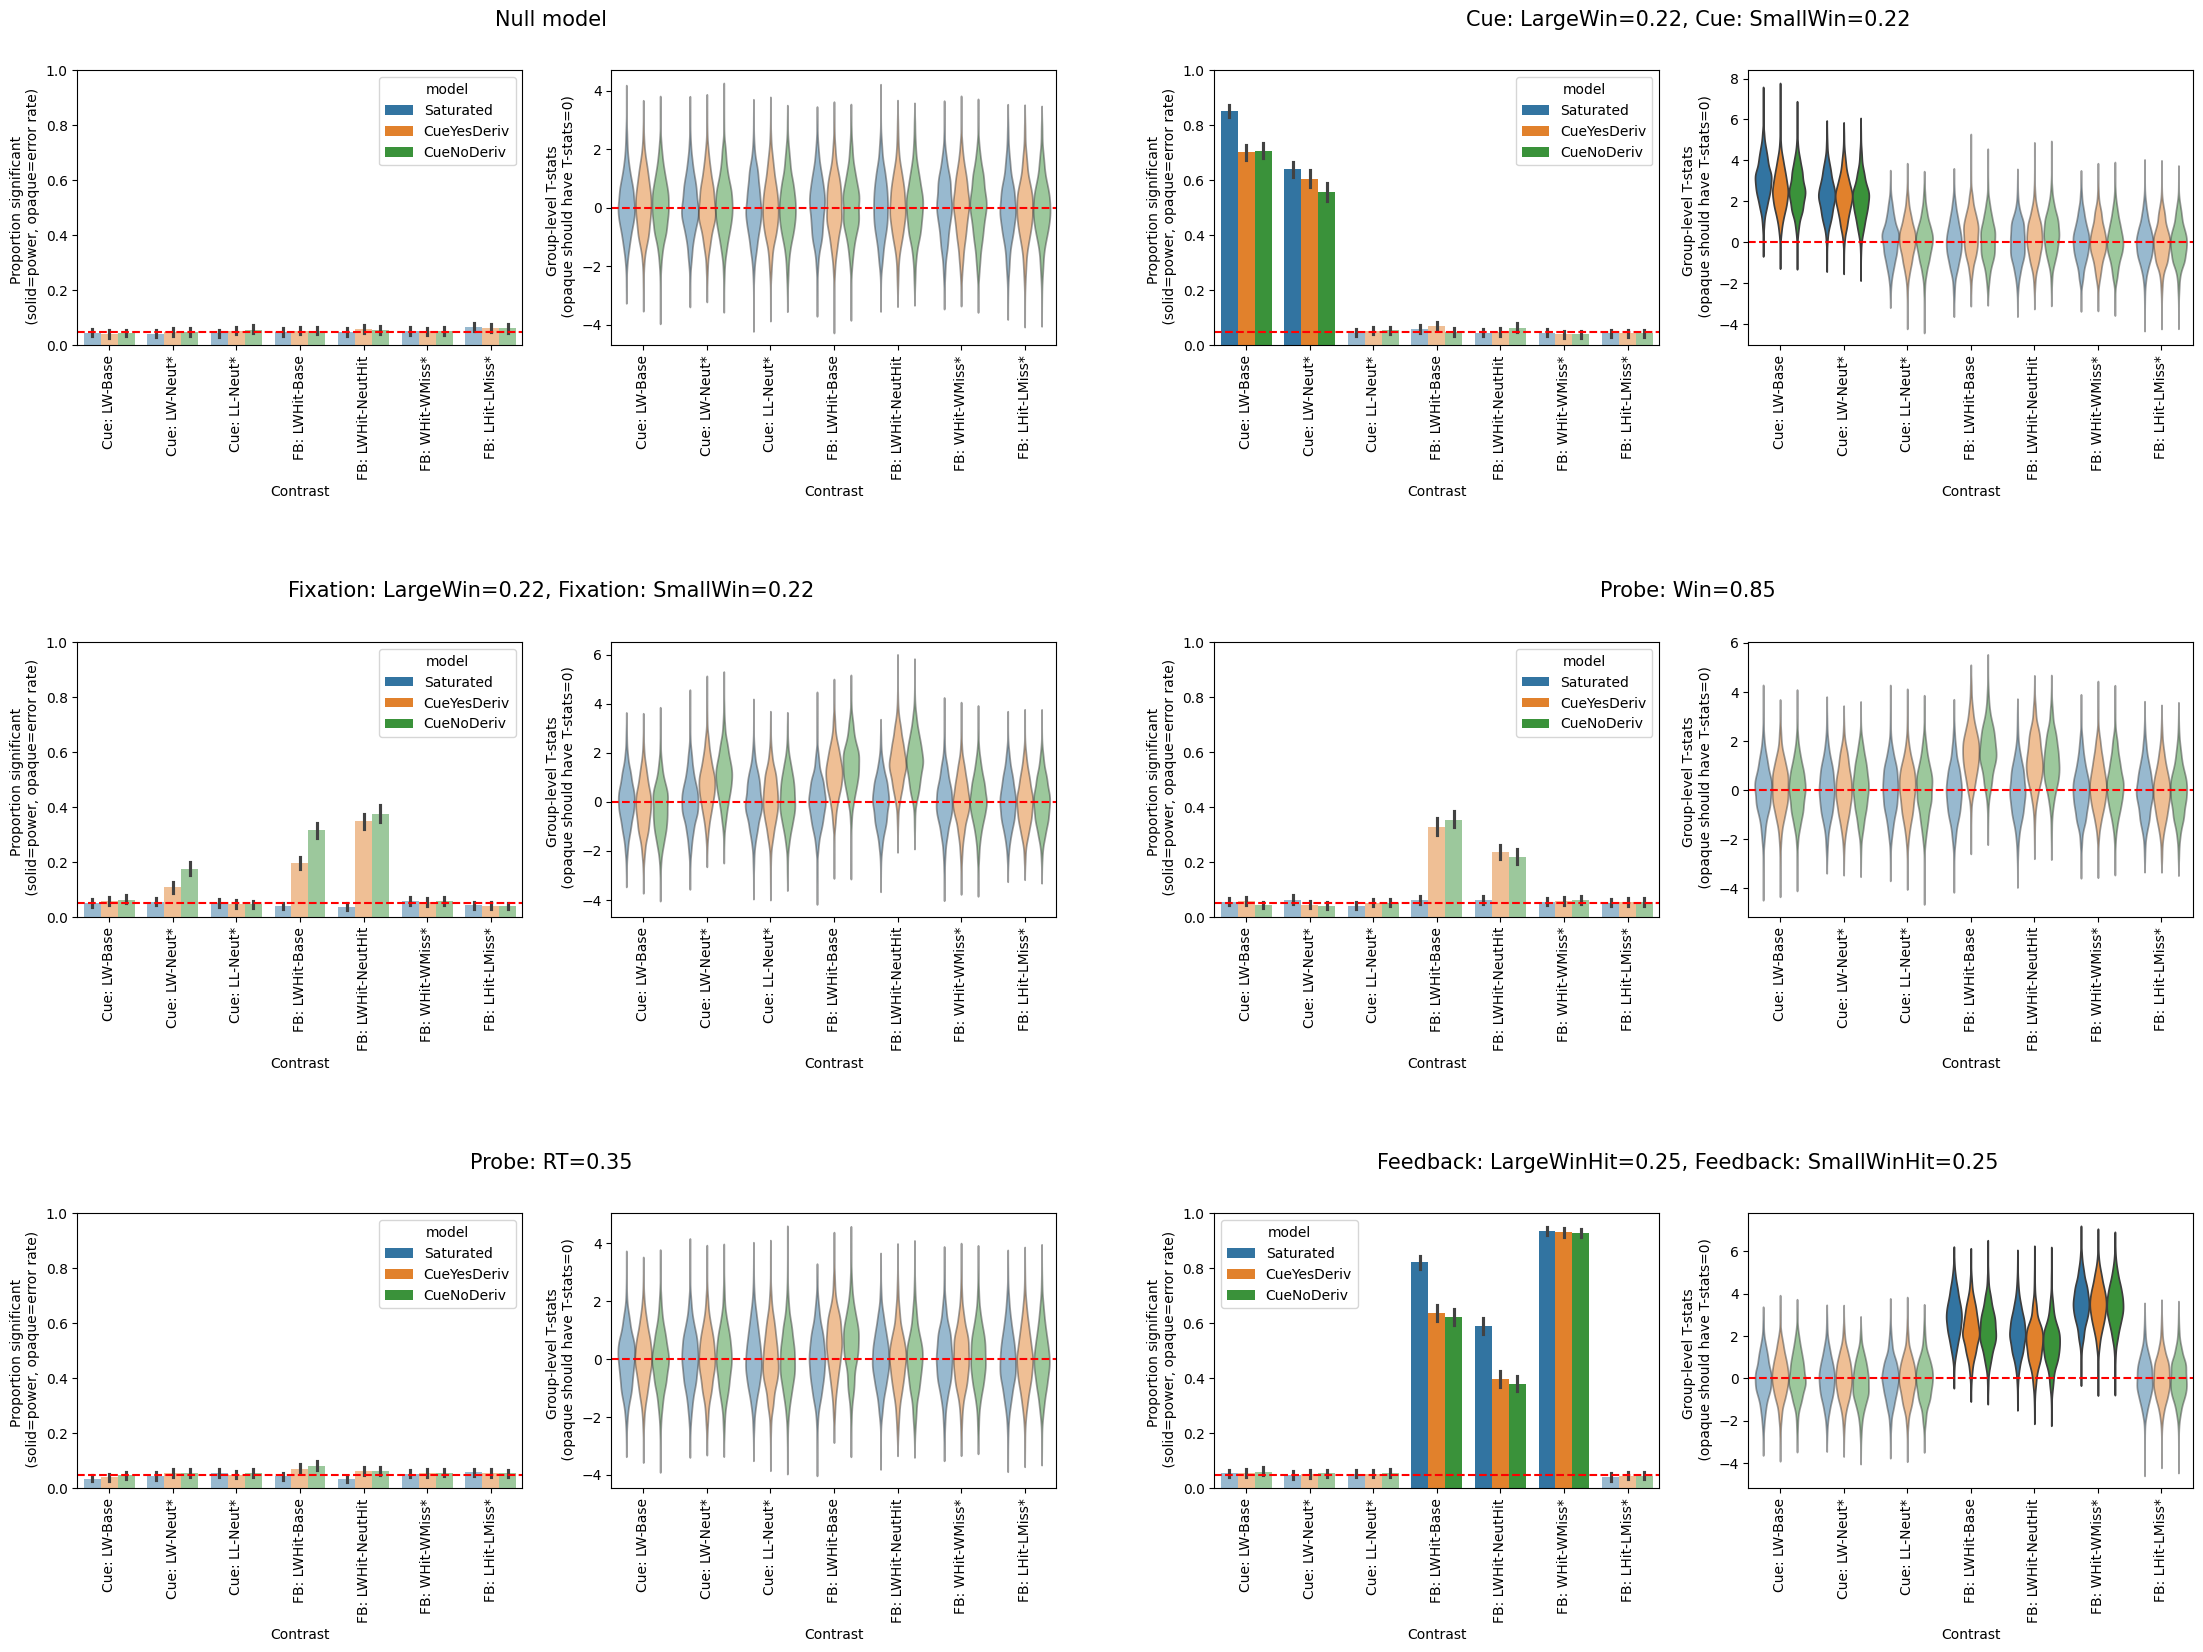

In [8]:
# Plot breaks if you don't enter an even number of results, so I include the null again.
results_plot = results.copy()
if len(results) % 2 != 0:
    results_plot.pop('Null model')
plot_dict_of_results(results_plot, contrasts=True)

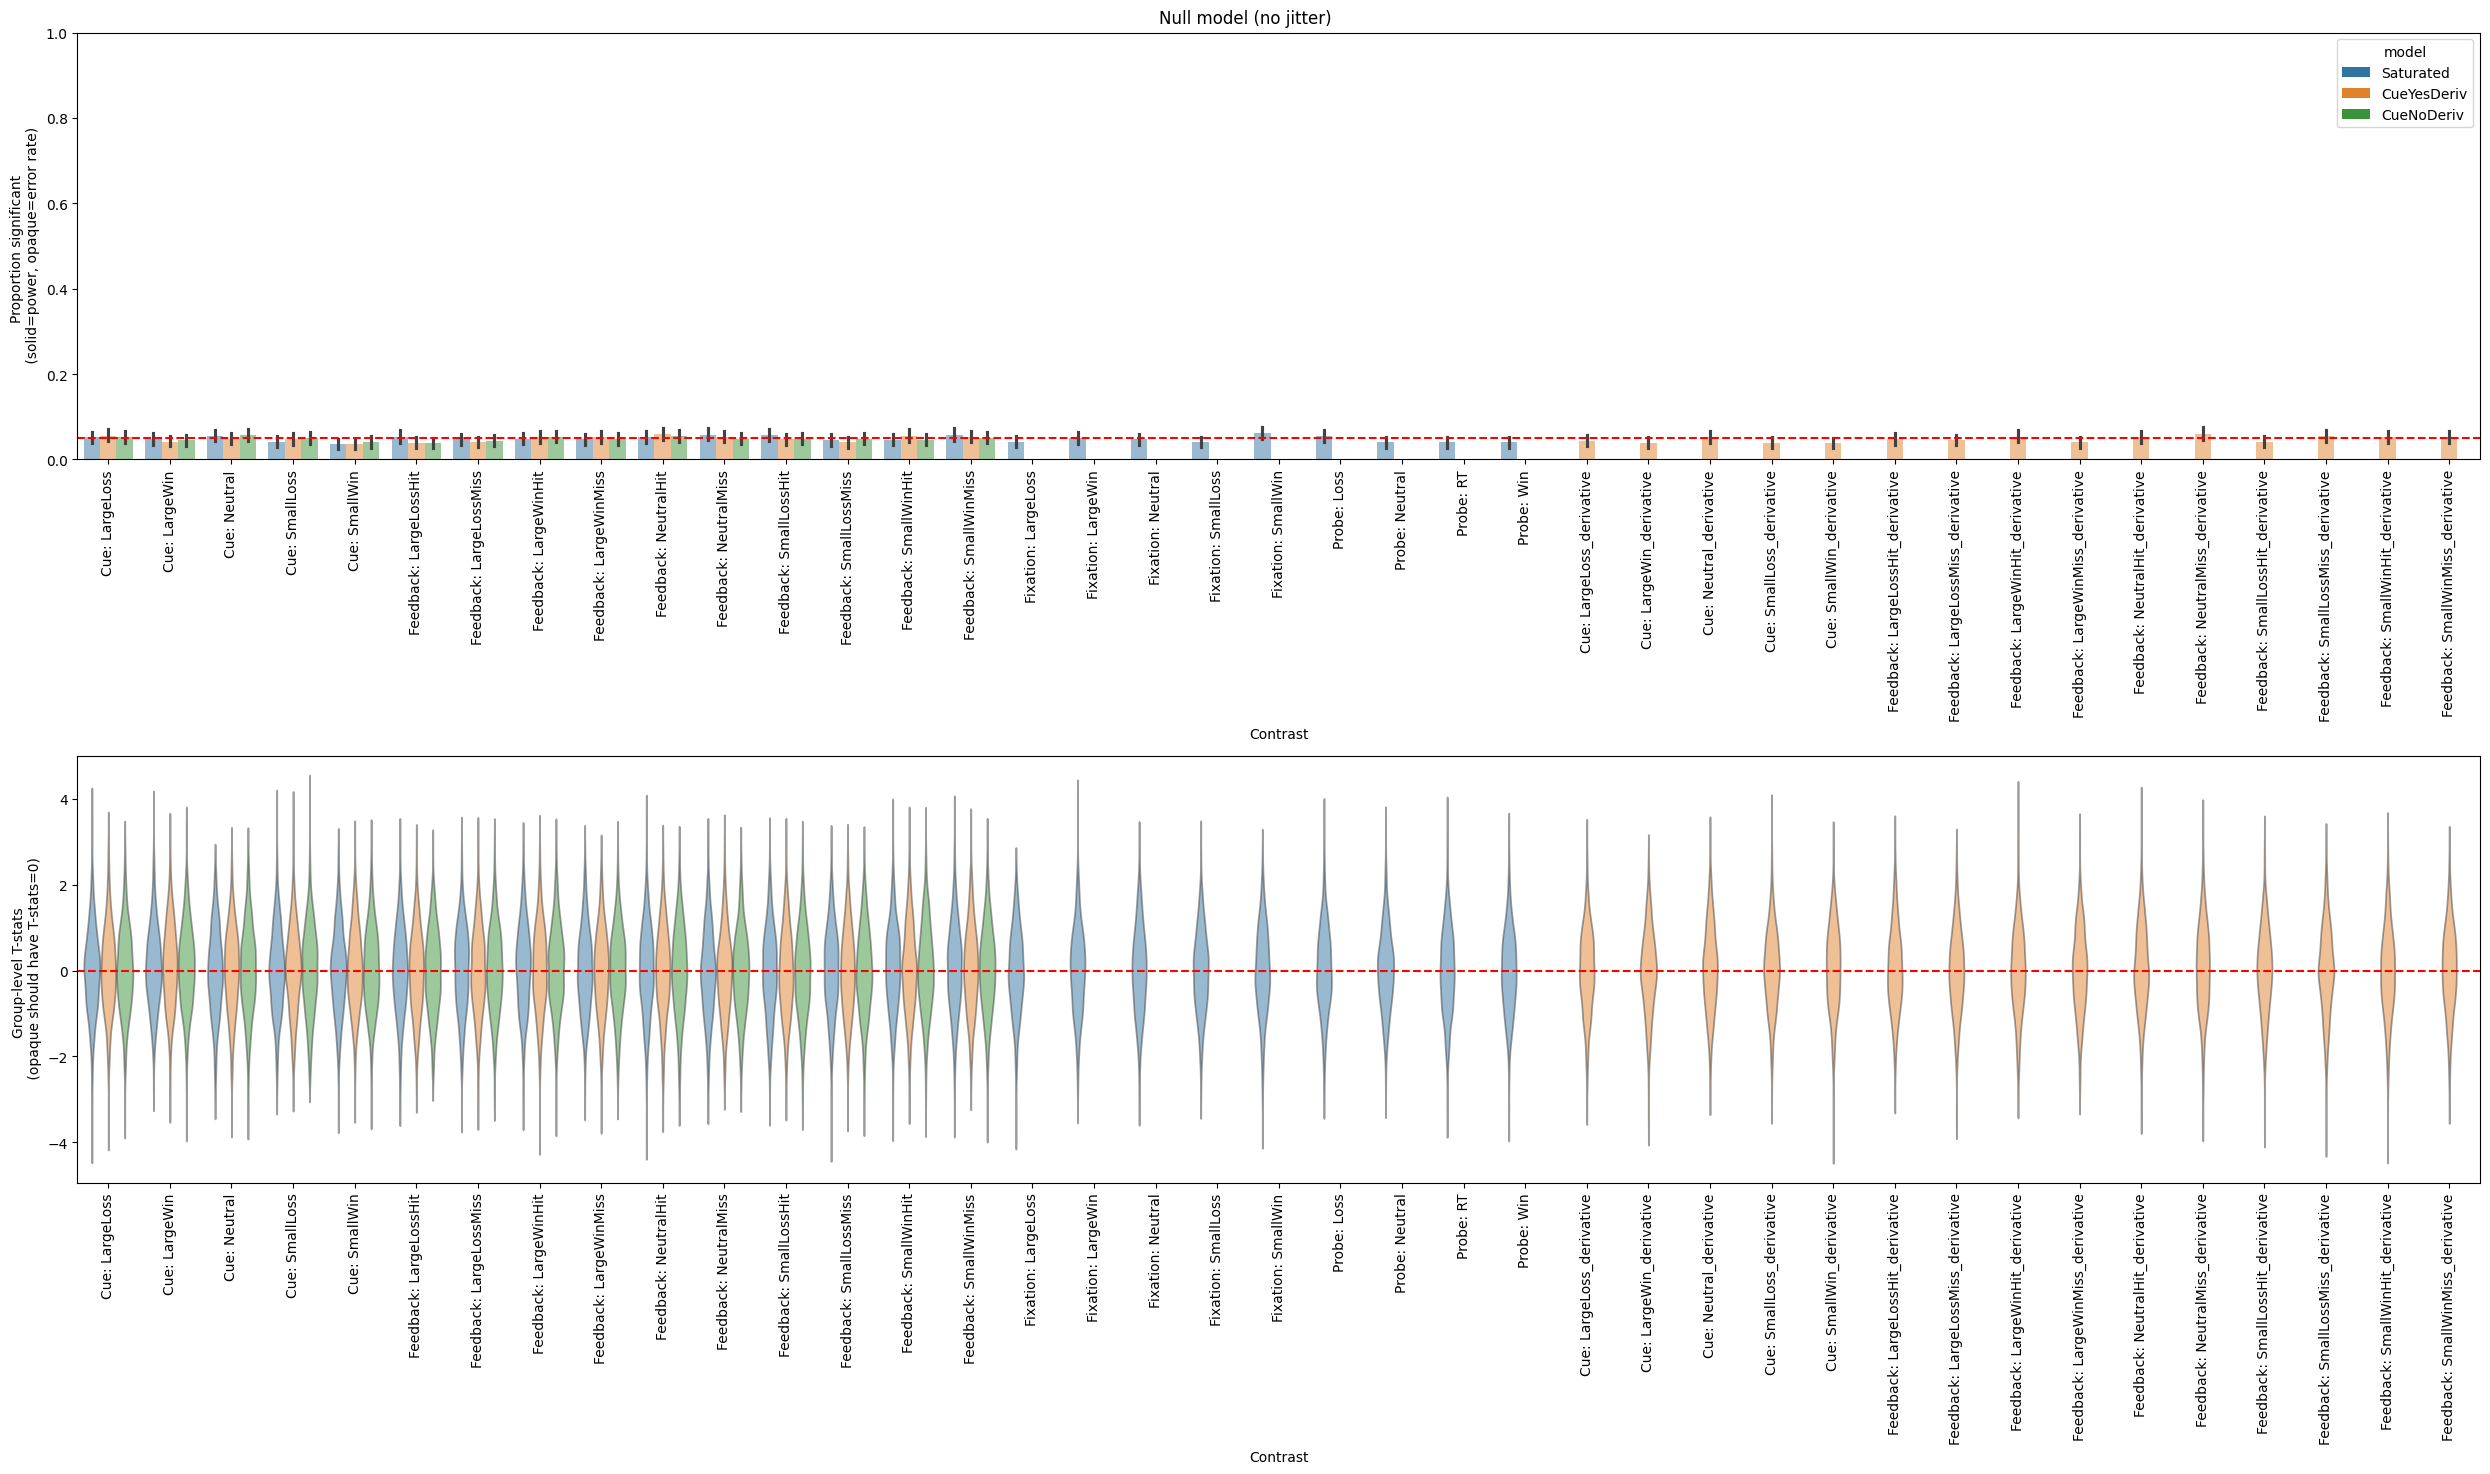

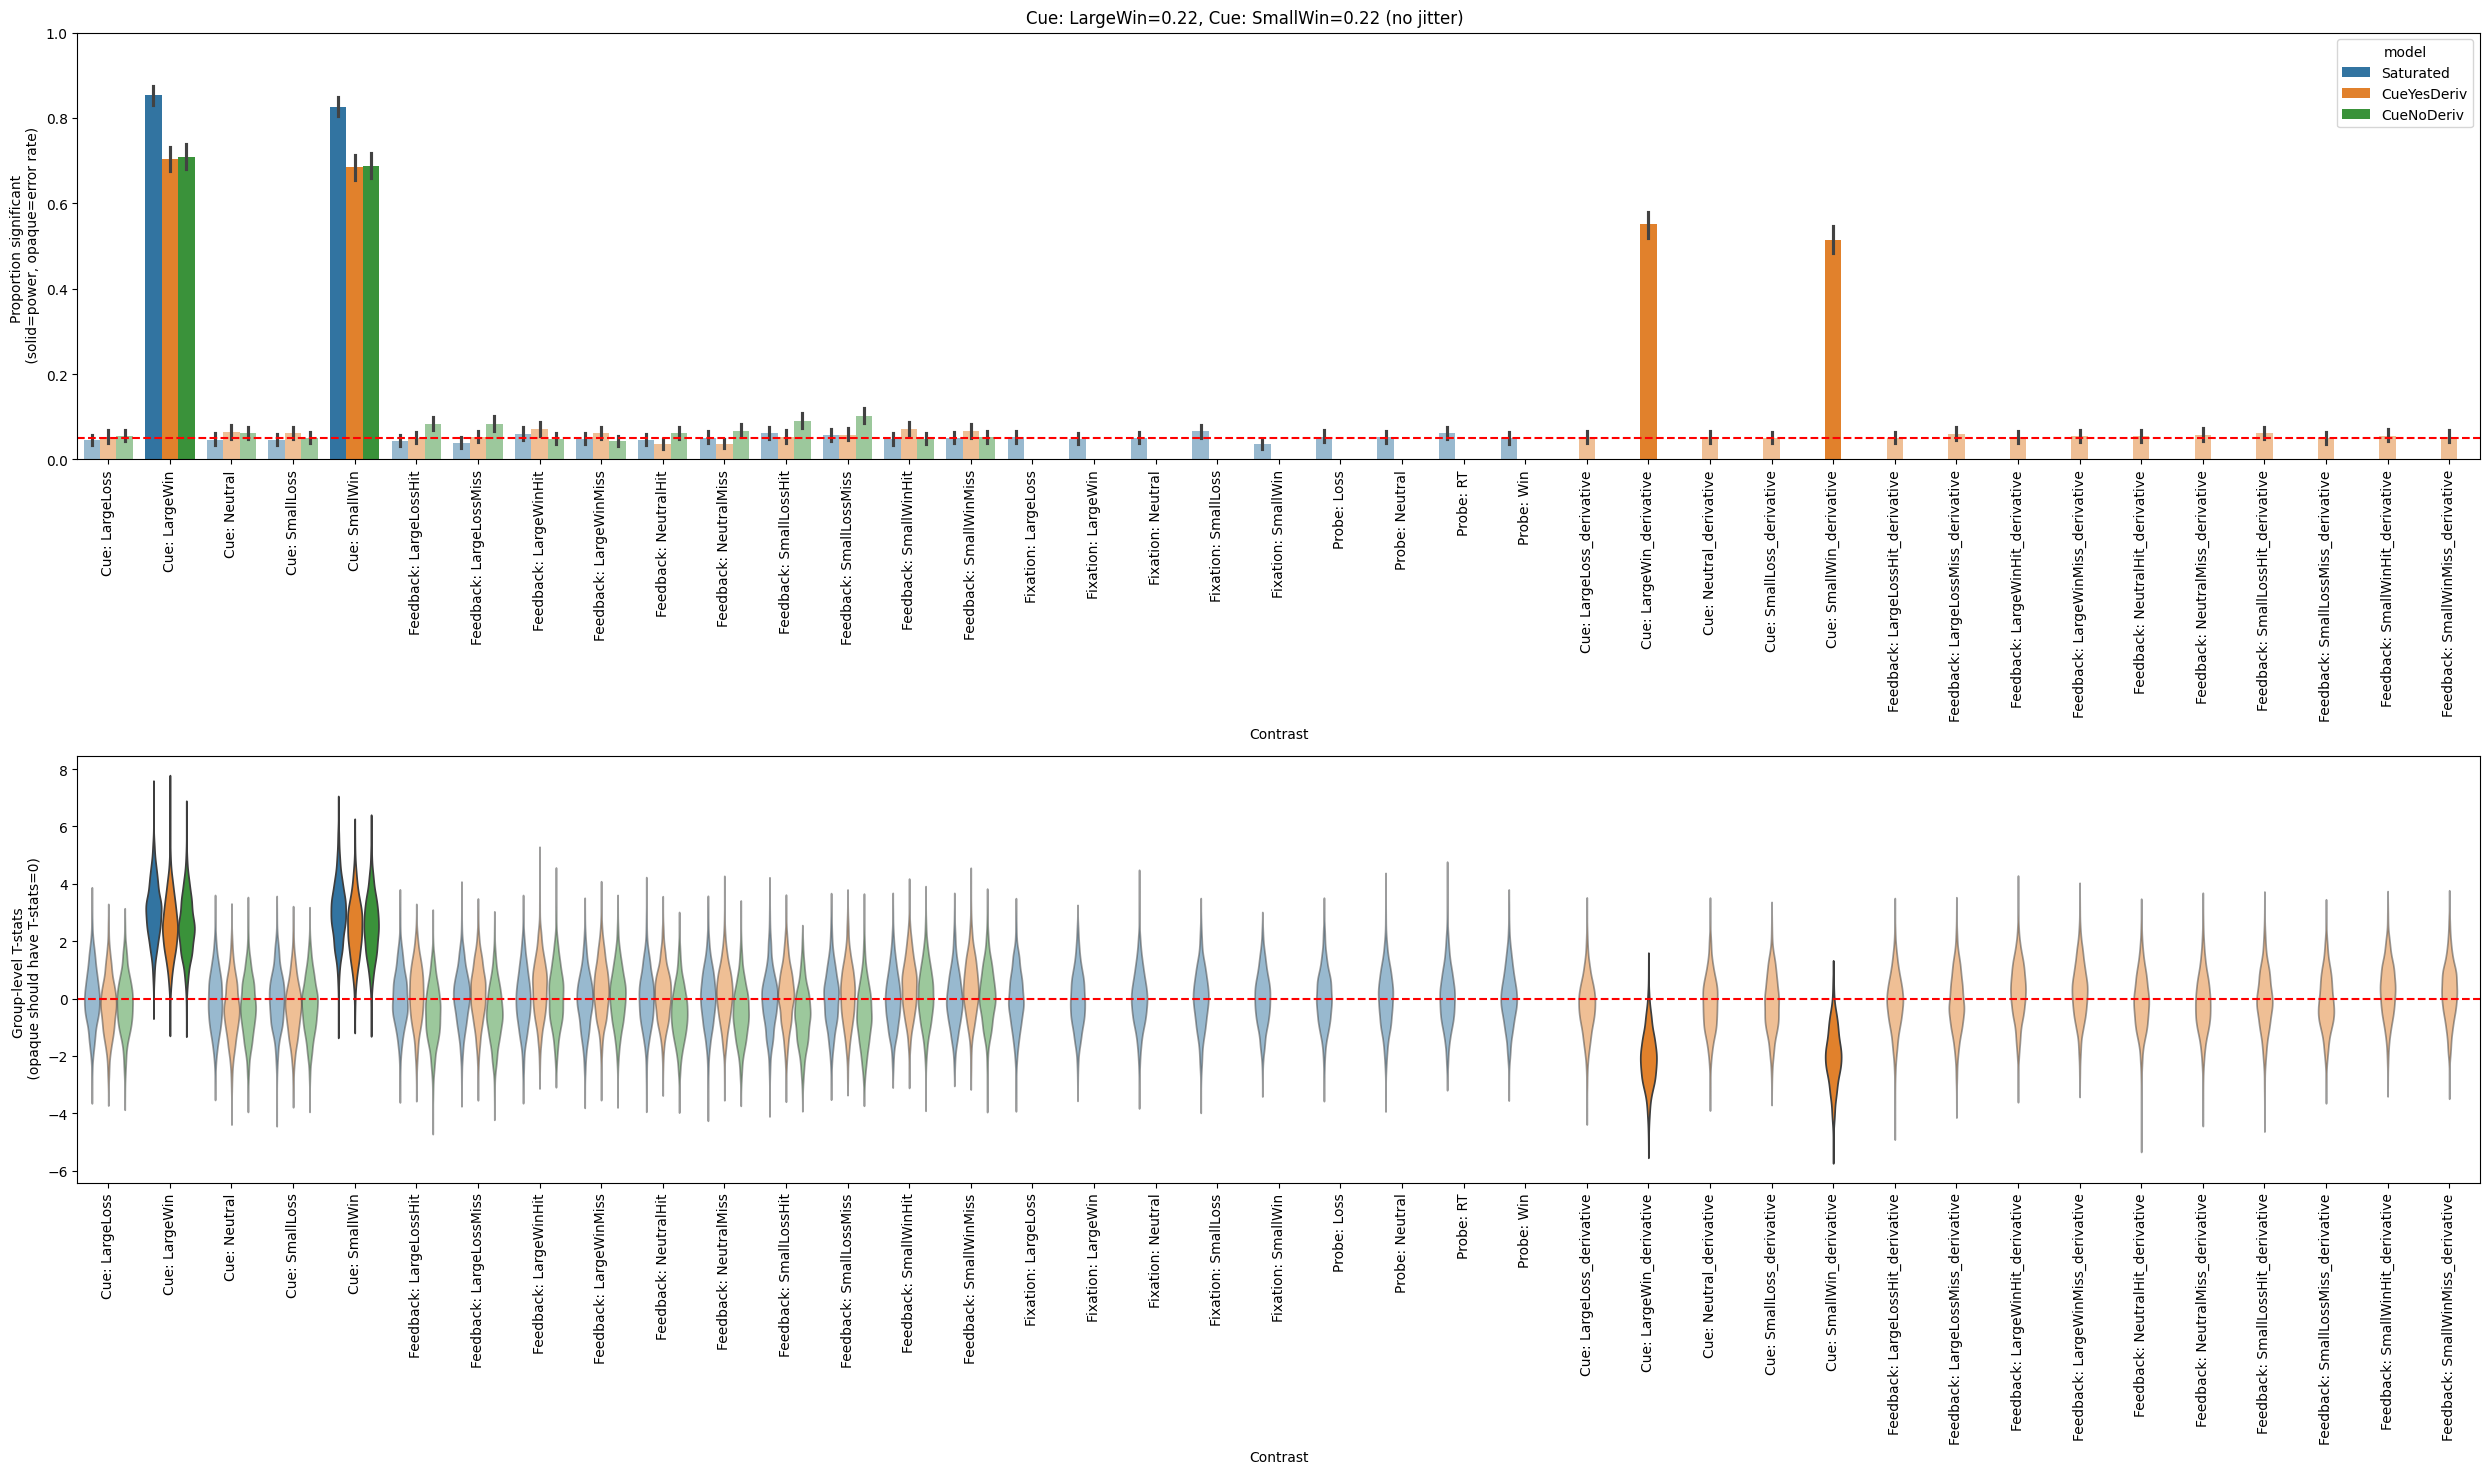

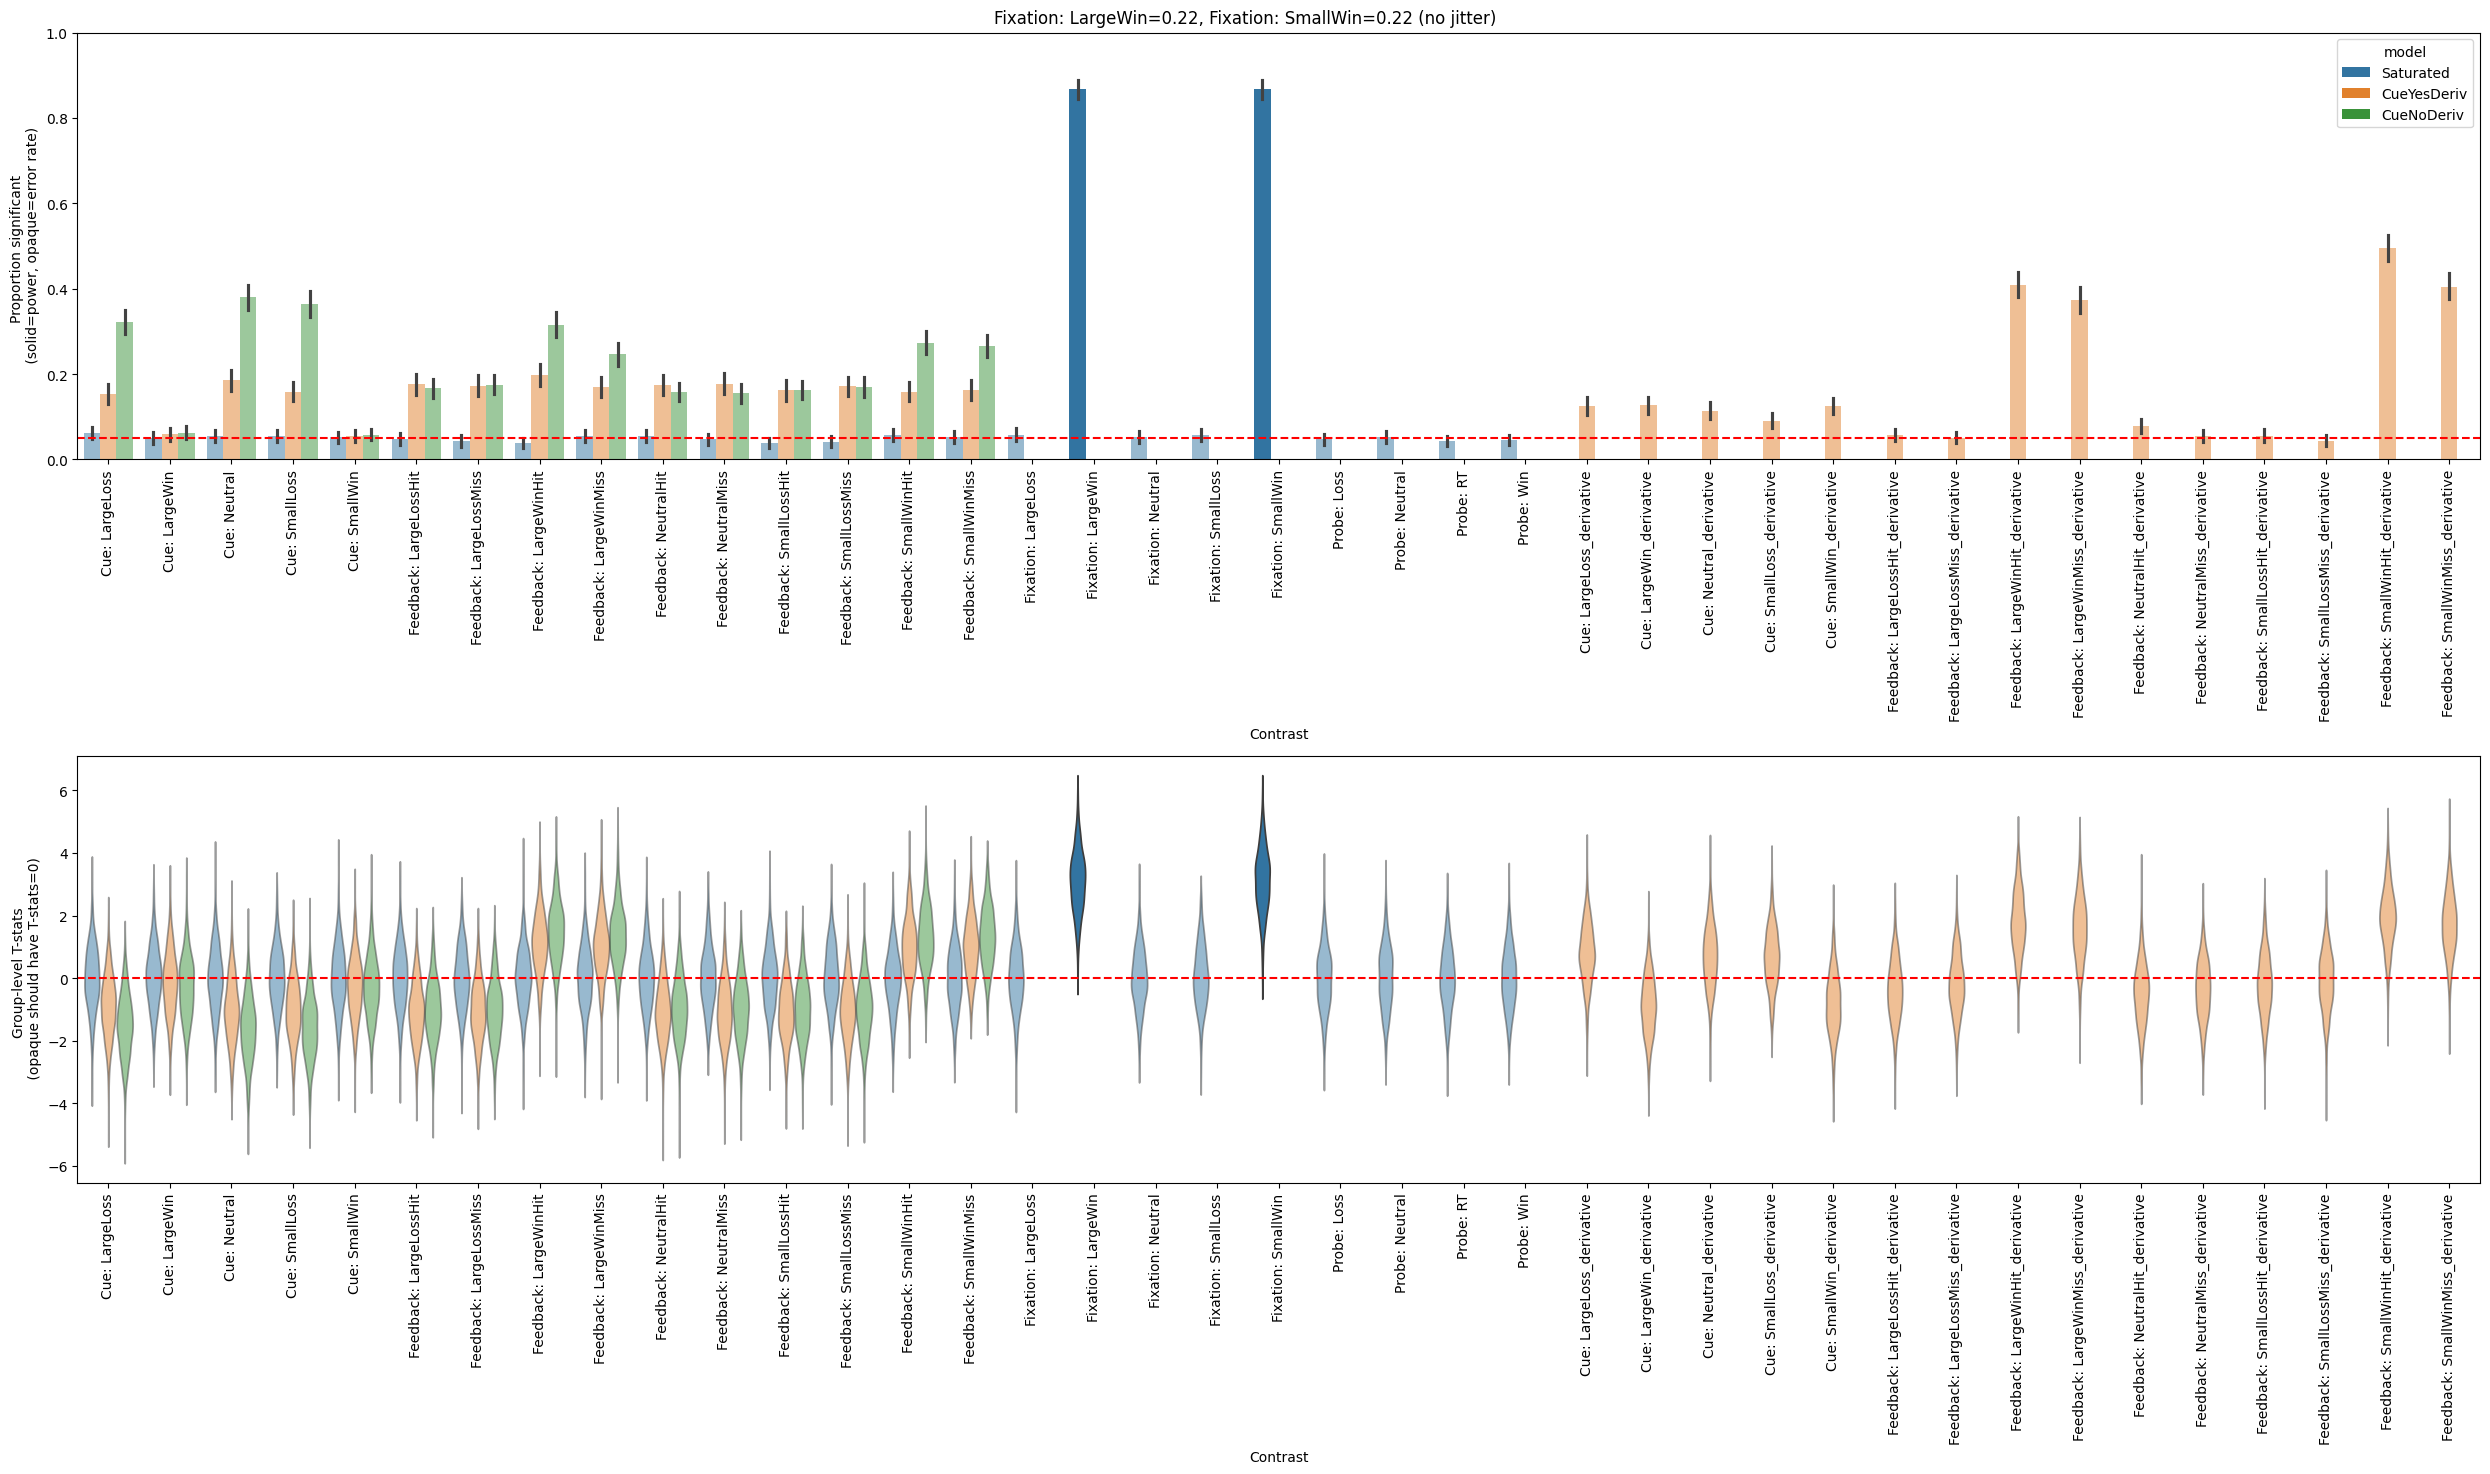

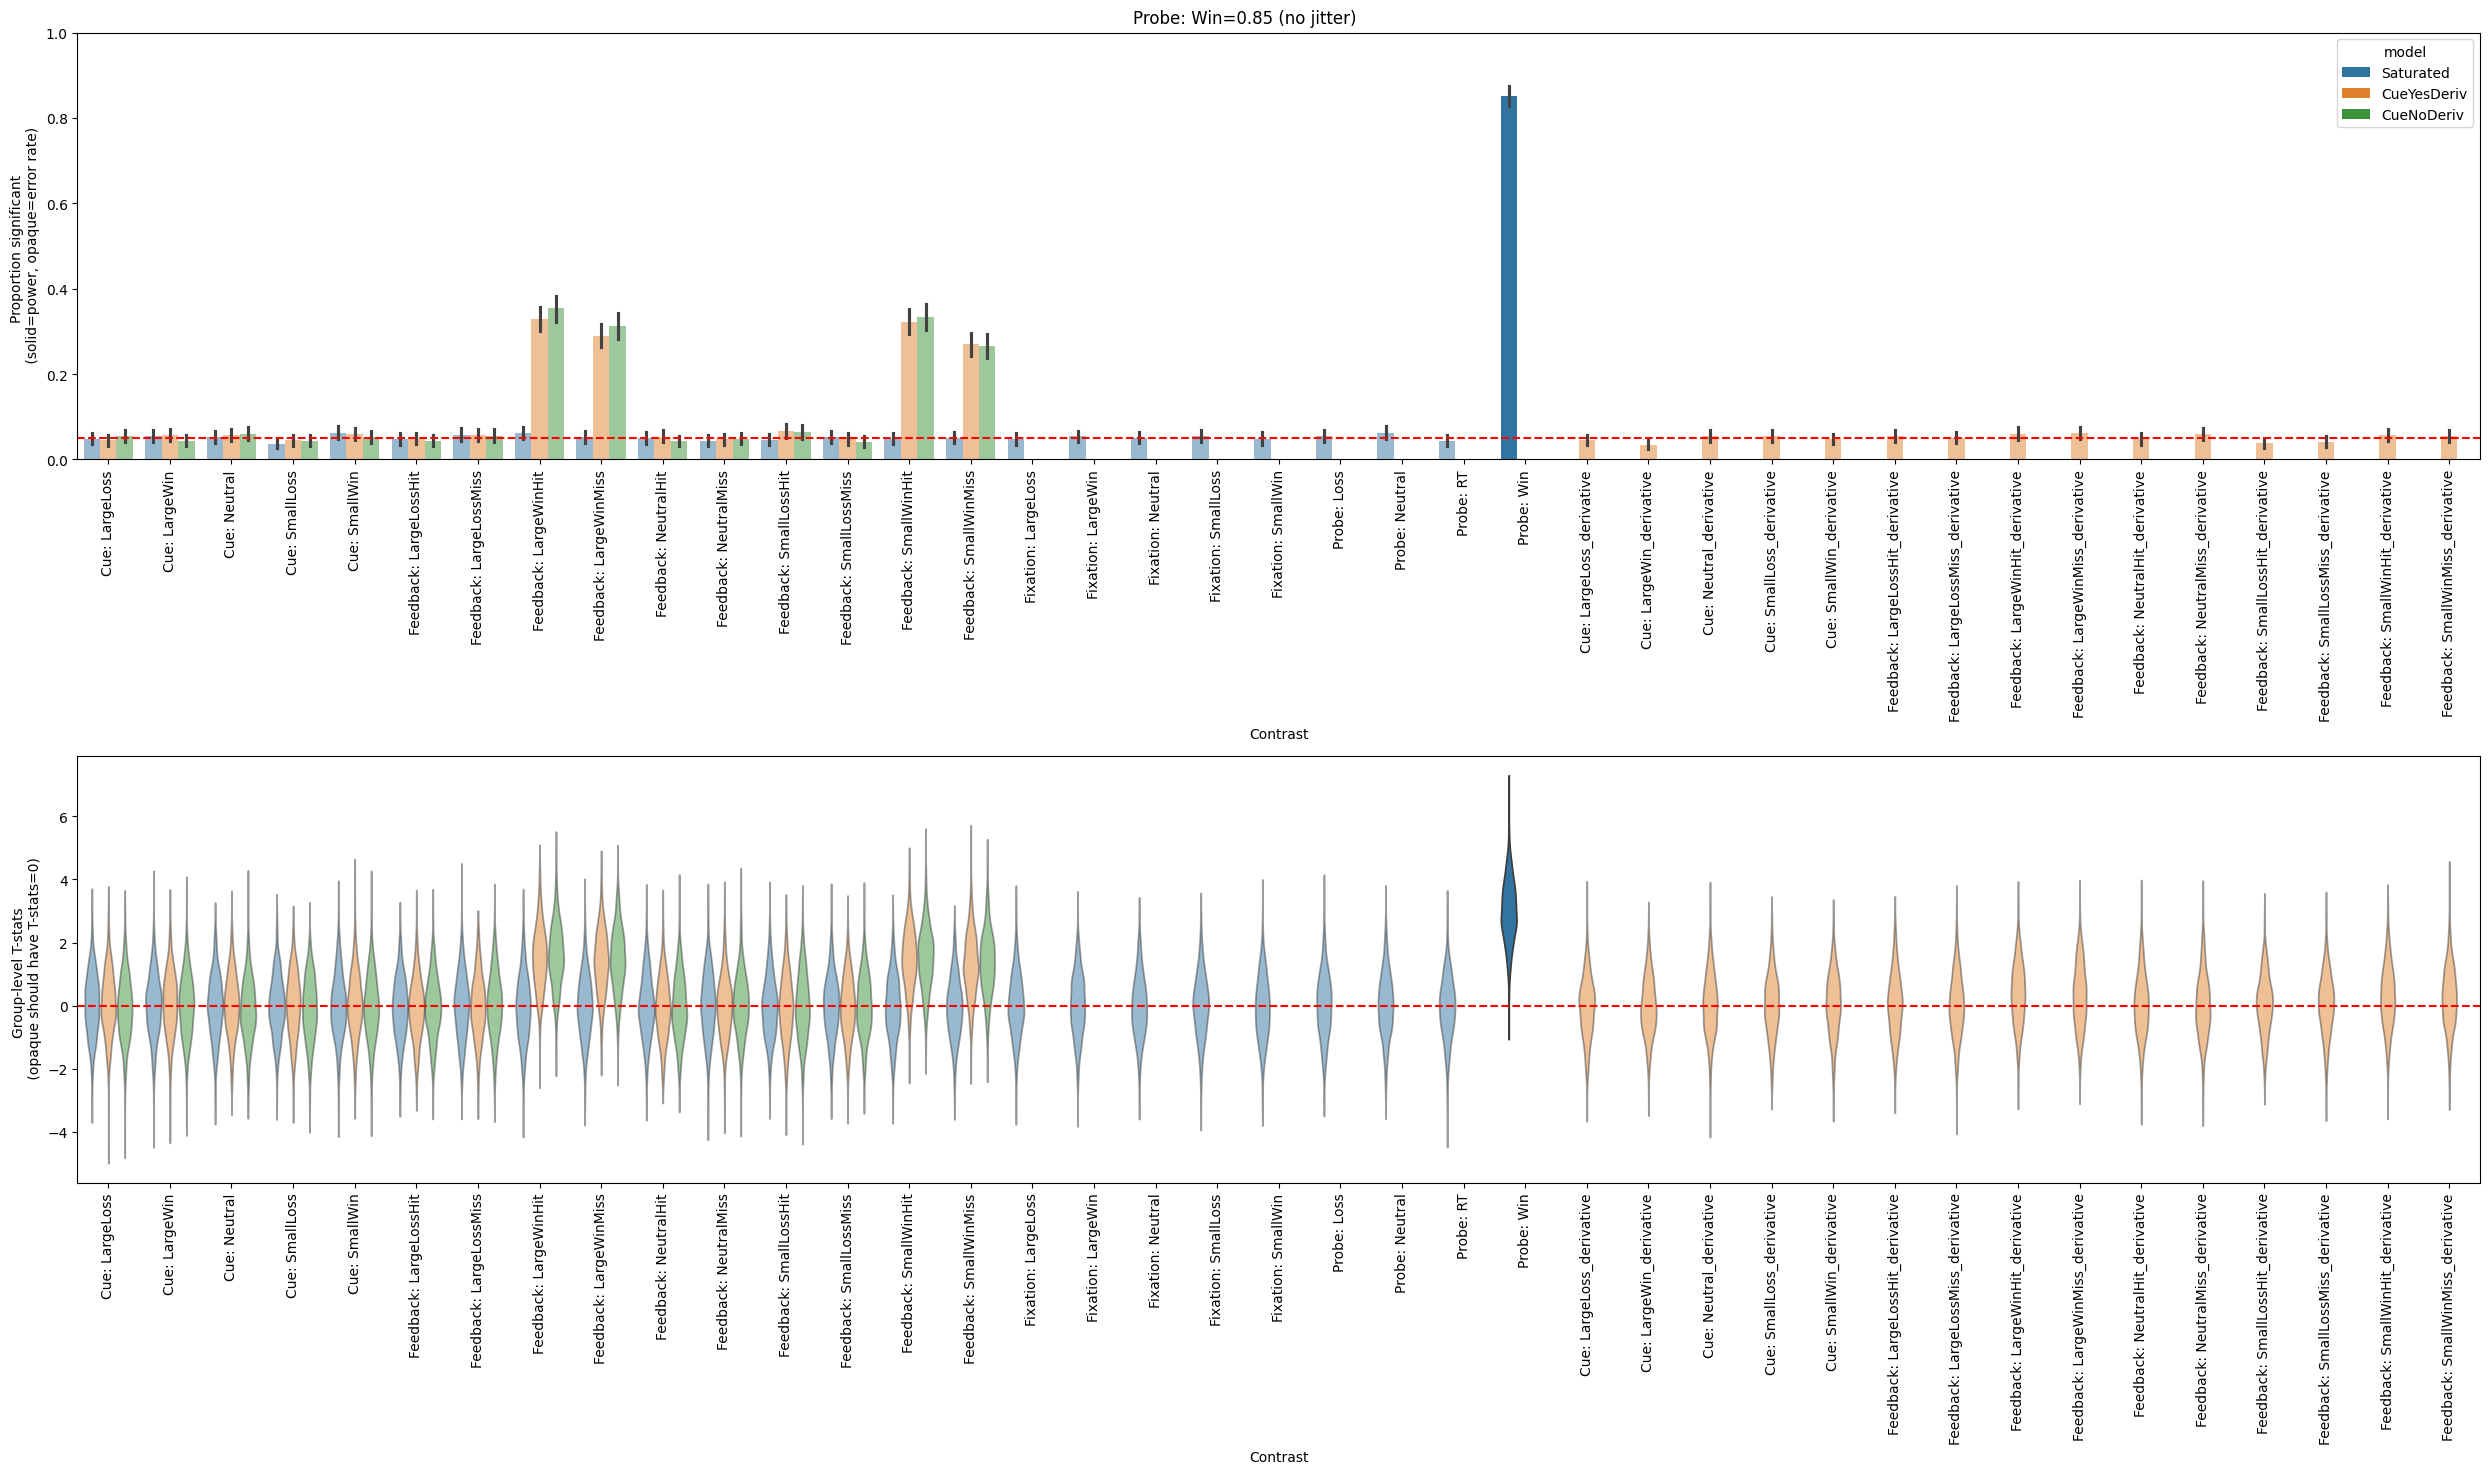

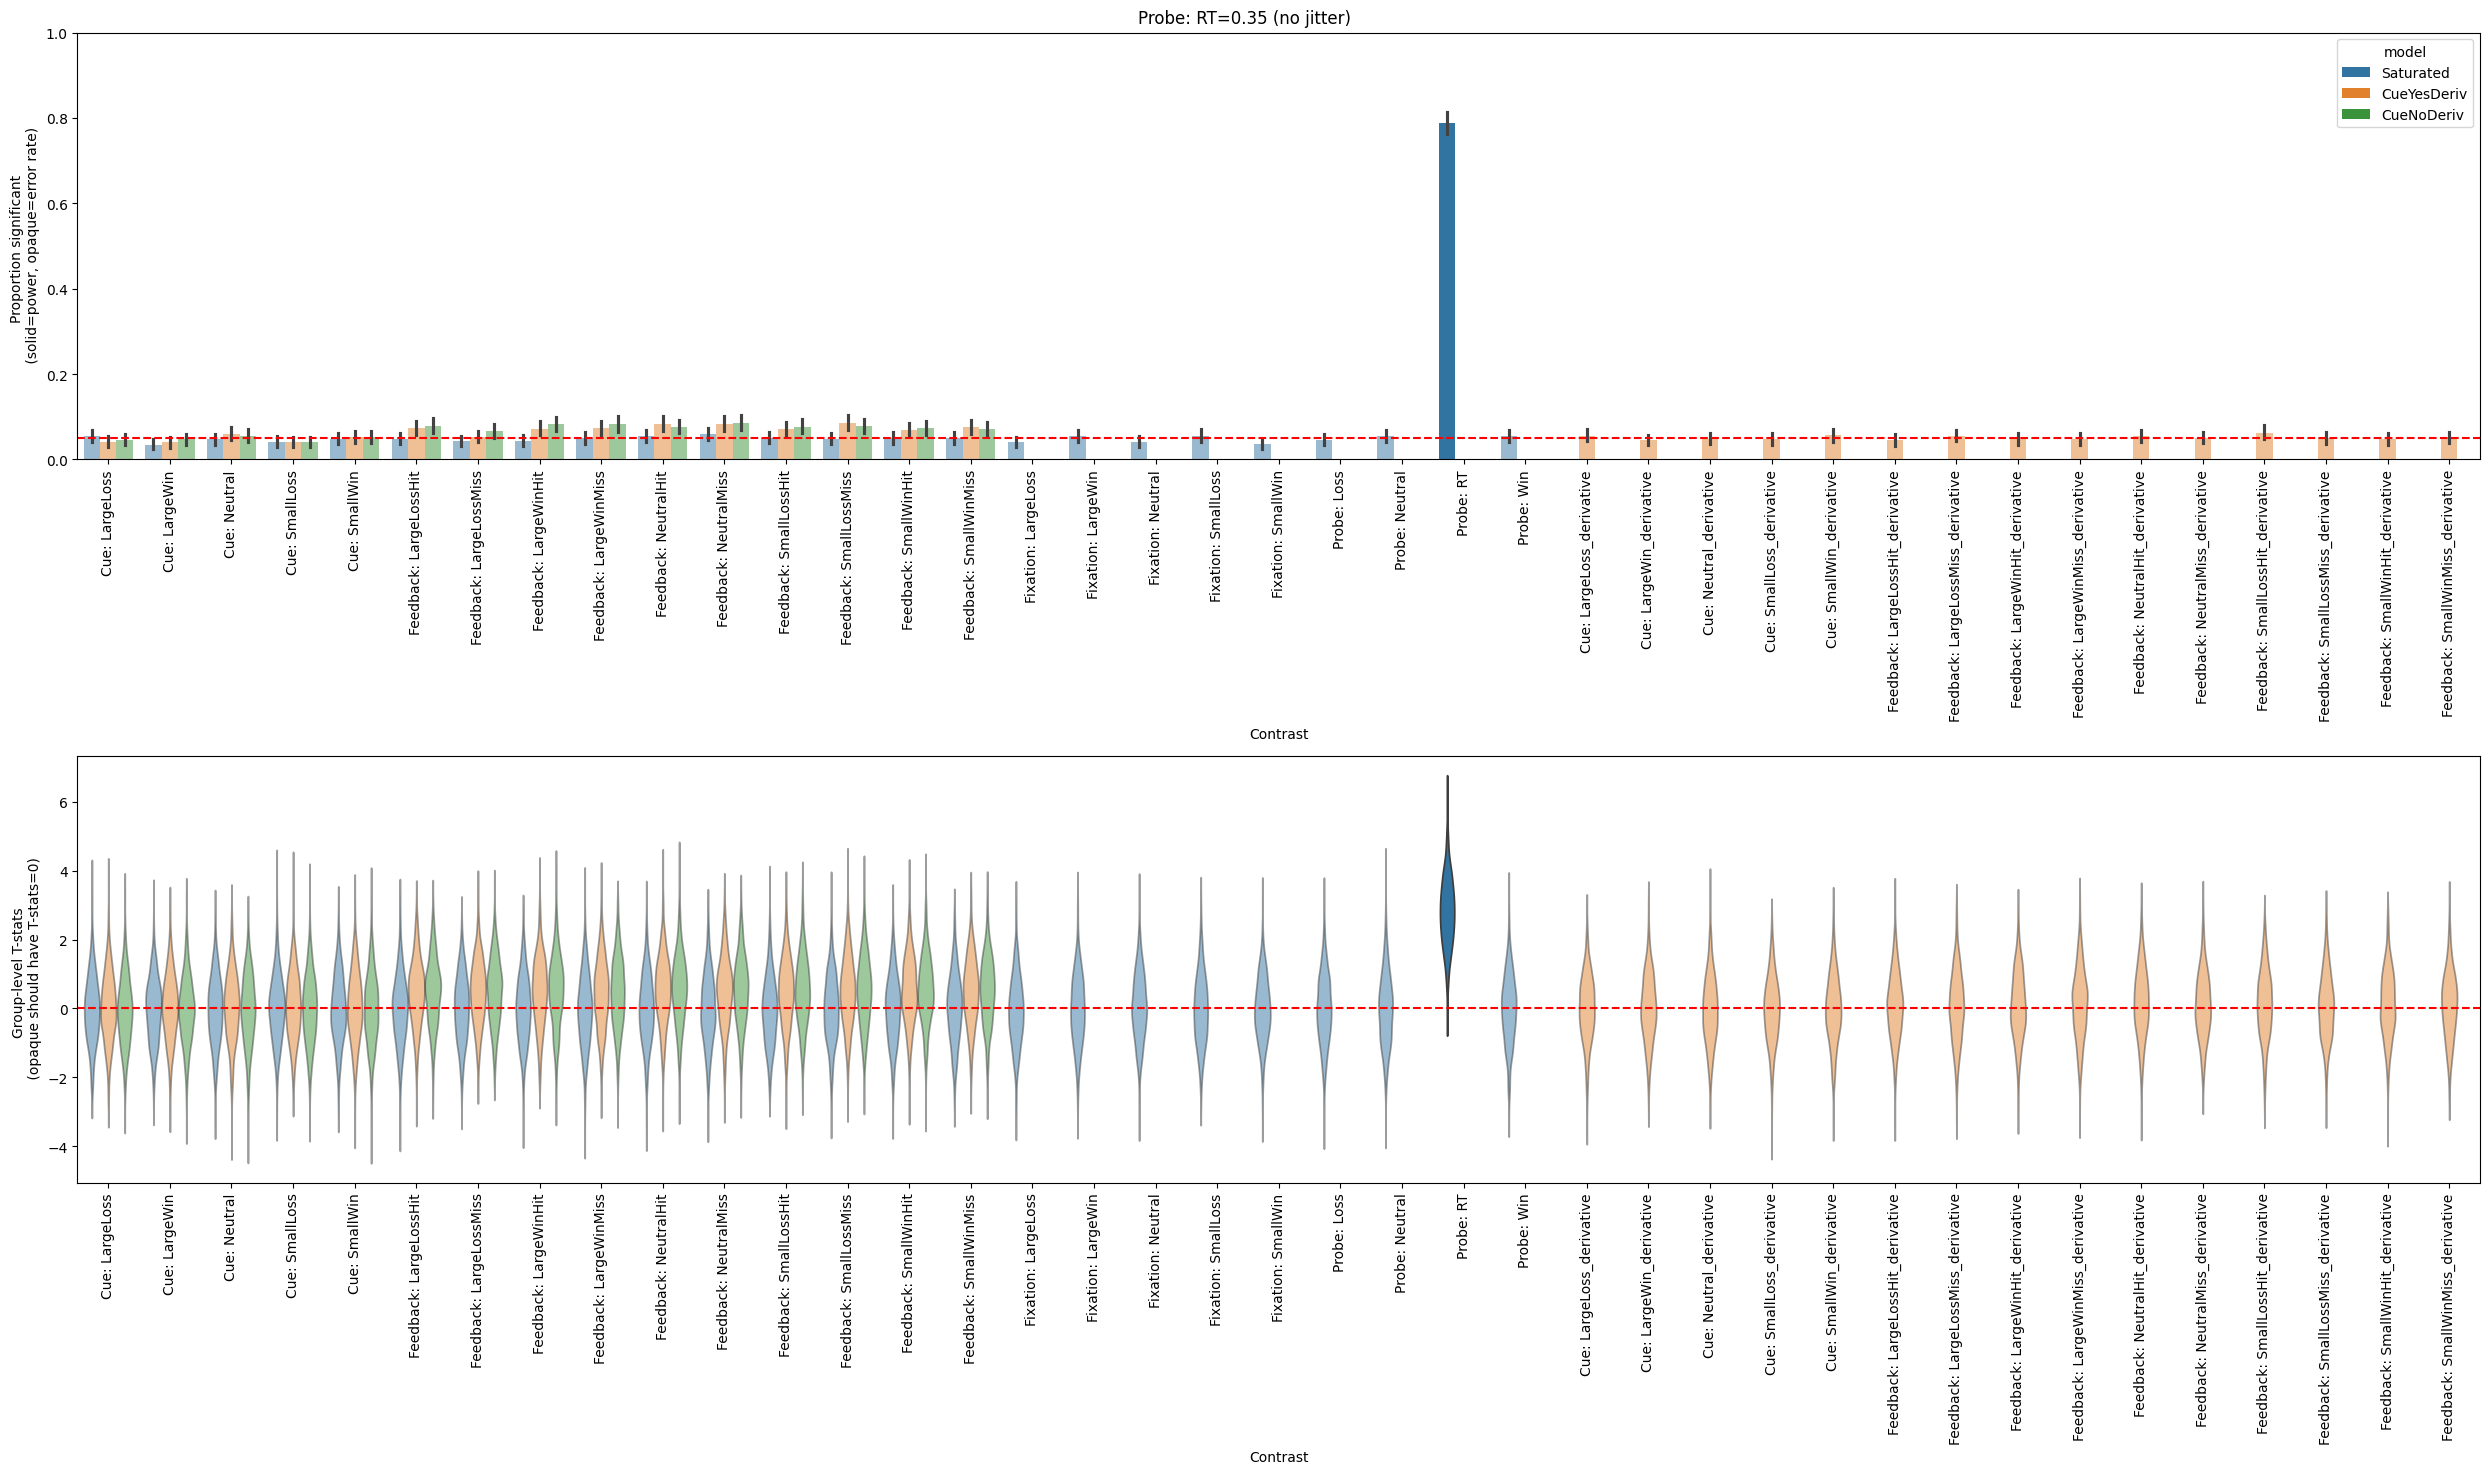

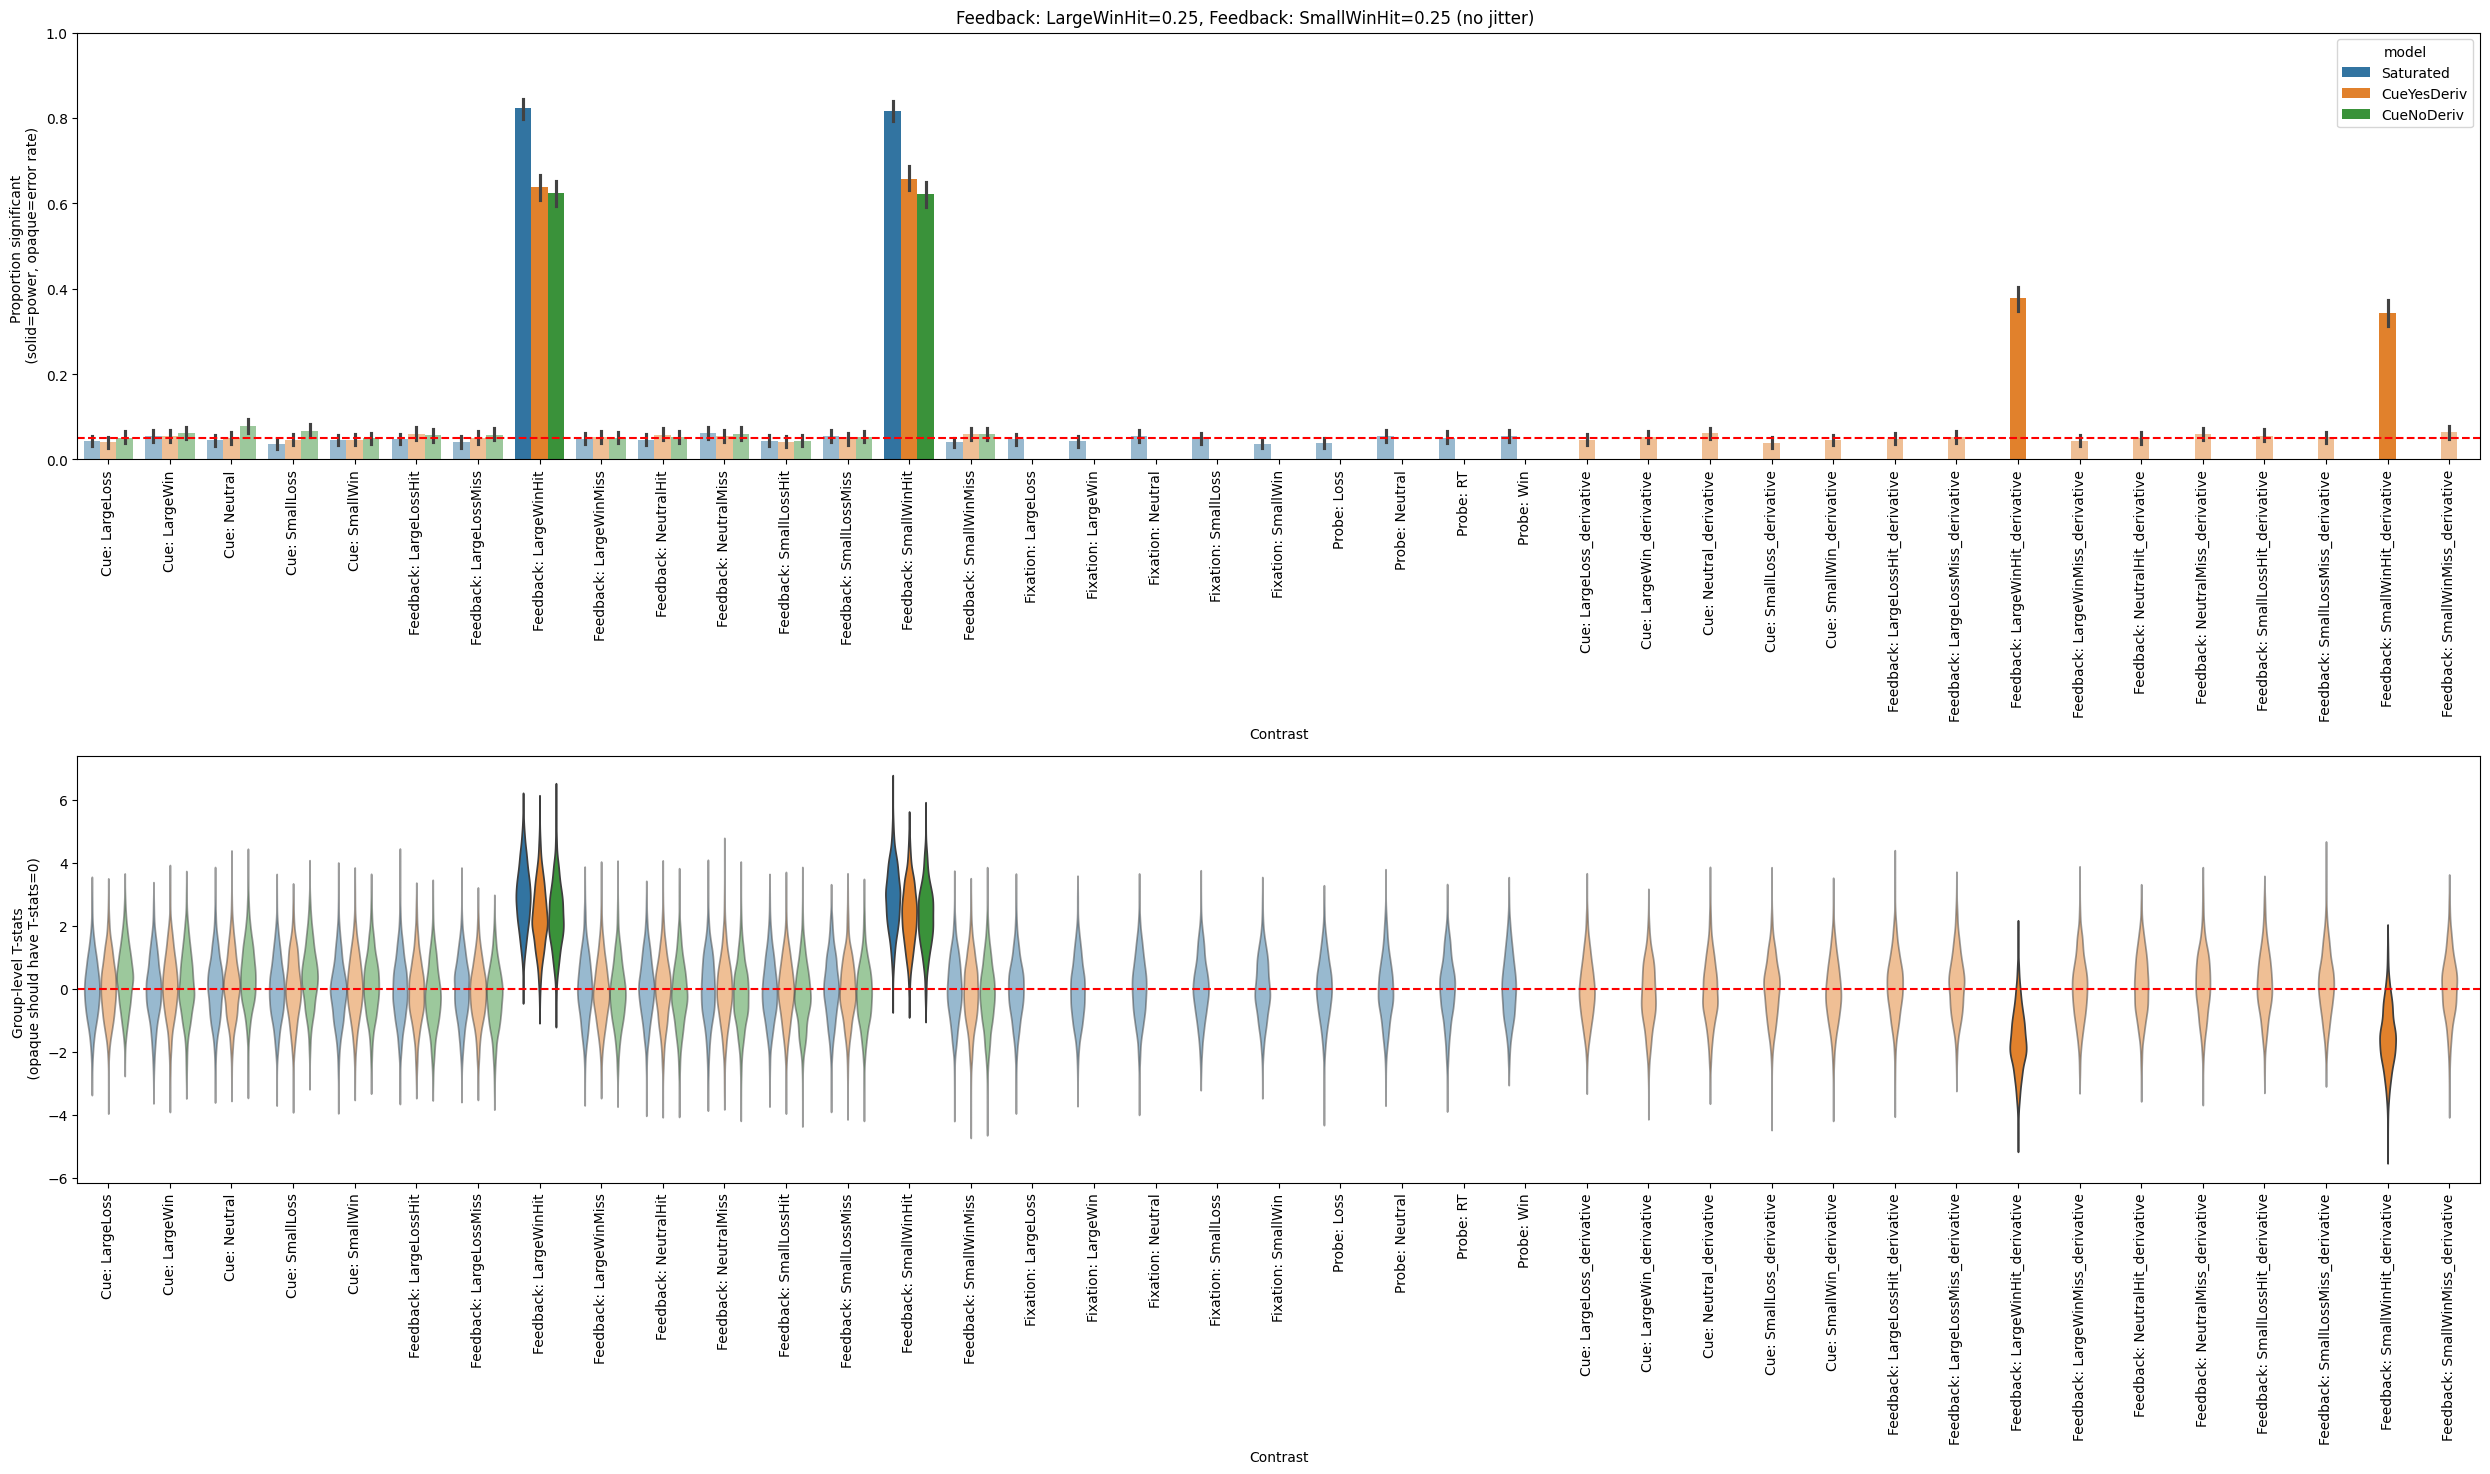

In [9]:
for name, result in results.items():
    result_loop = result[~result['contrast'].str.contains('-|Derivative')].copy()
    plot_results(result_loop, f'{name} (no jitter)', stacked=True)

### Bias and error rate grids used in manuscript and supplement

In [10]:
results_trimmed = results.copy()
omit_keys = [
    'Cue: LargeWin=0.15, Cue: SmallWin=0.15, Fixation: LargeWin=0.15, Fixation: SmallWin=0.15',
    'Cue: LargeWin=0.15, Cue: SmallWin=0.15, Fixation: LargeWin=0.15, Fixation: SmallWin=0.15, Probe=0.5, Probe: RT=0.3',
    'Feedback: LargeWinHit=0.09, Feedback: LargeWinMiss=-0.09',
]
for key in omit_keys:
    if key in results_trimmed.keys():
        results_trimmed.pop(key)

# Omitting contrasts that aren't impacted by the signals introduced
contrasts_to_remove = ['Cue: LL-Neut*', 'FB: LHit-LMiss*']

# Create a filtered copy of the dictionary
results_filtered = {
    key: results_trimmed[~results_trimmed['contrast'].isin(contrasts_to_remove)].copy()
    for key, results_trimmed in results_trimmed.items()
}

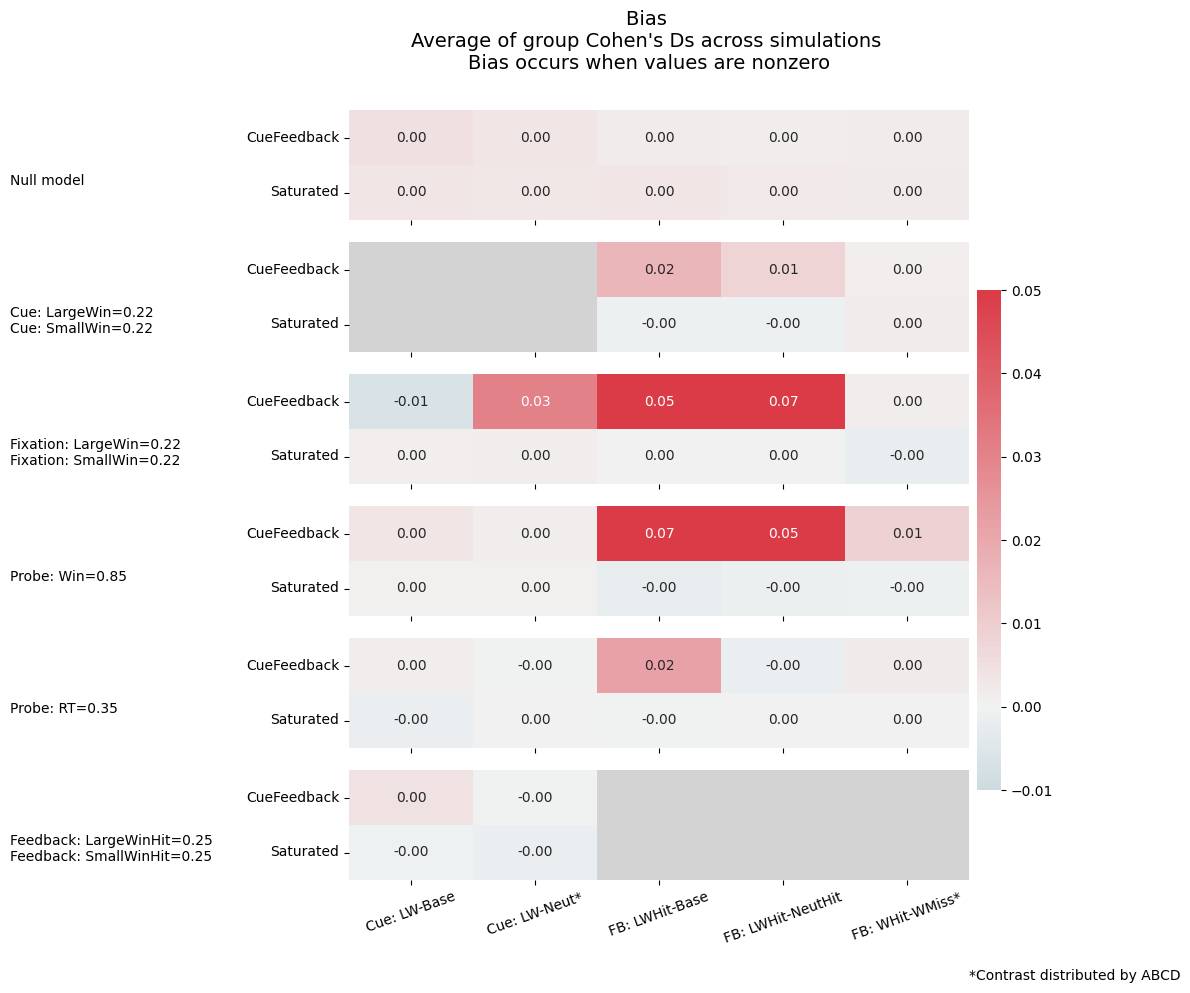

In [12]:
fig_path = f'{figure_output_path}/bias_grid_no_jitter.pdf'
plot_bias(
    results_filtered,
    contrasts_only=True,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='CueFeedback',
)

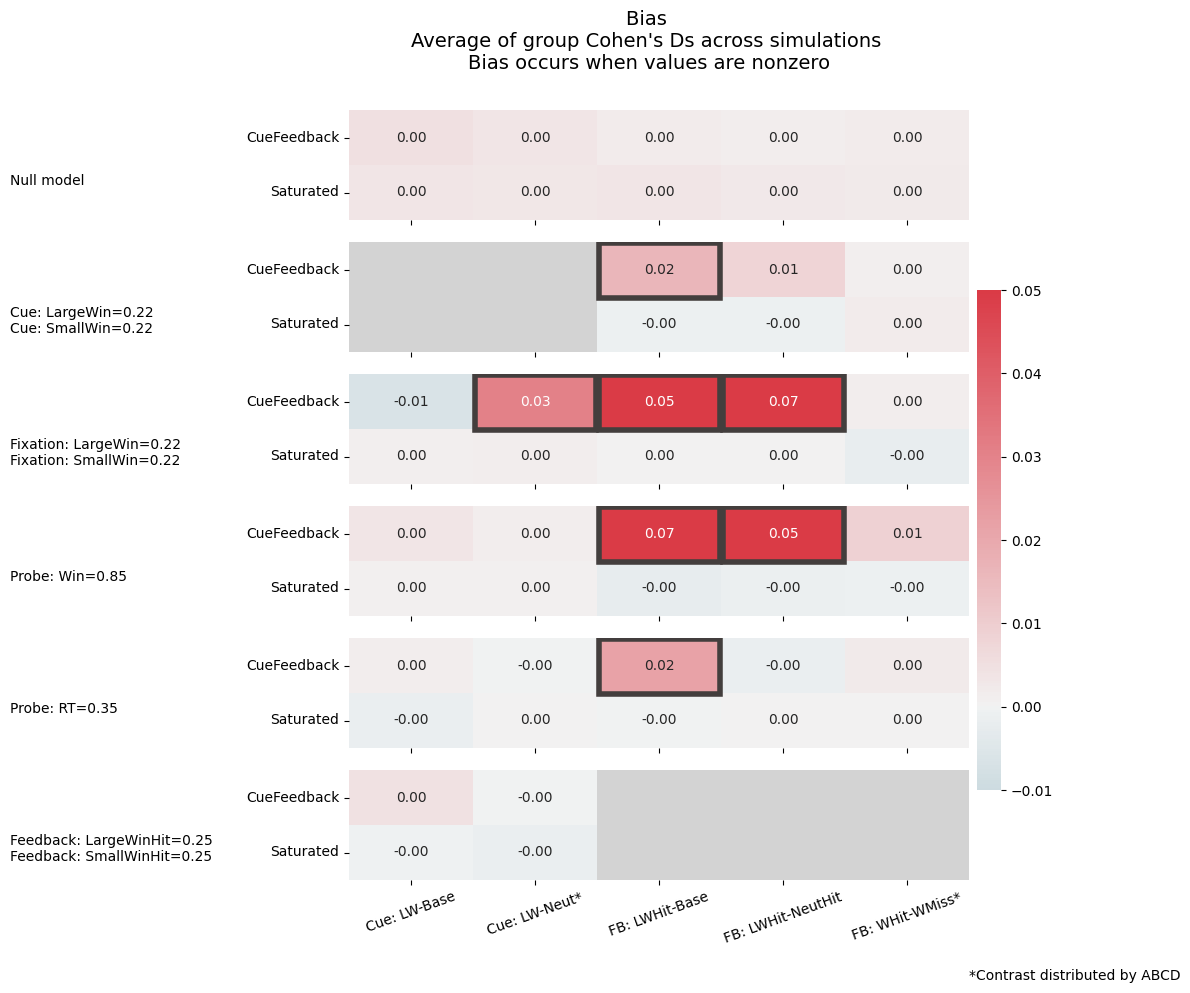

In [13]:
fig_path = f'{figure_output_path}/bias_grid_no_jitter_sig.pdf'

plot_bias_significance(
    results_filtered,
    contrasts_only=True,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='CueFeedback',
)

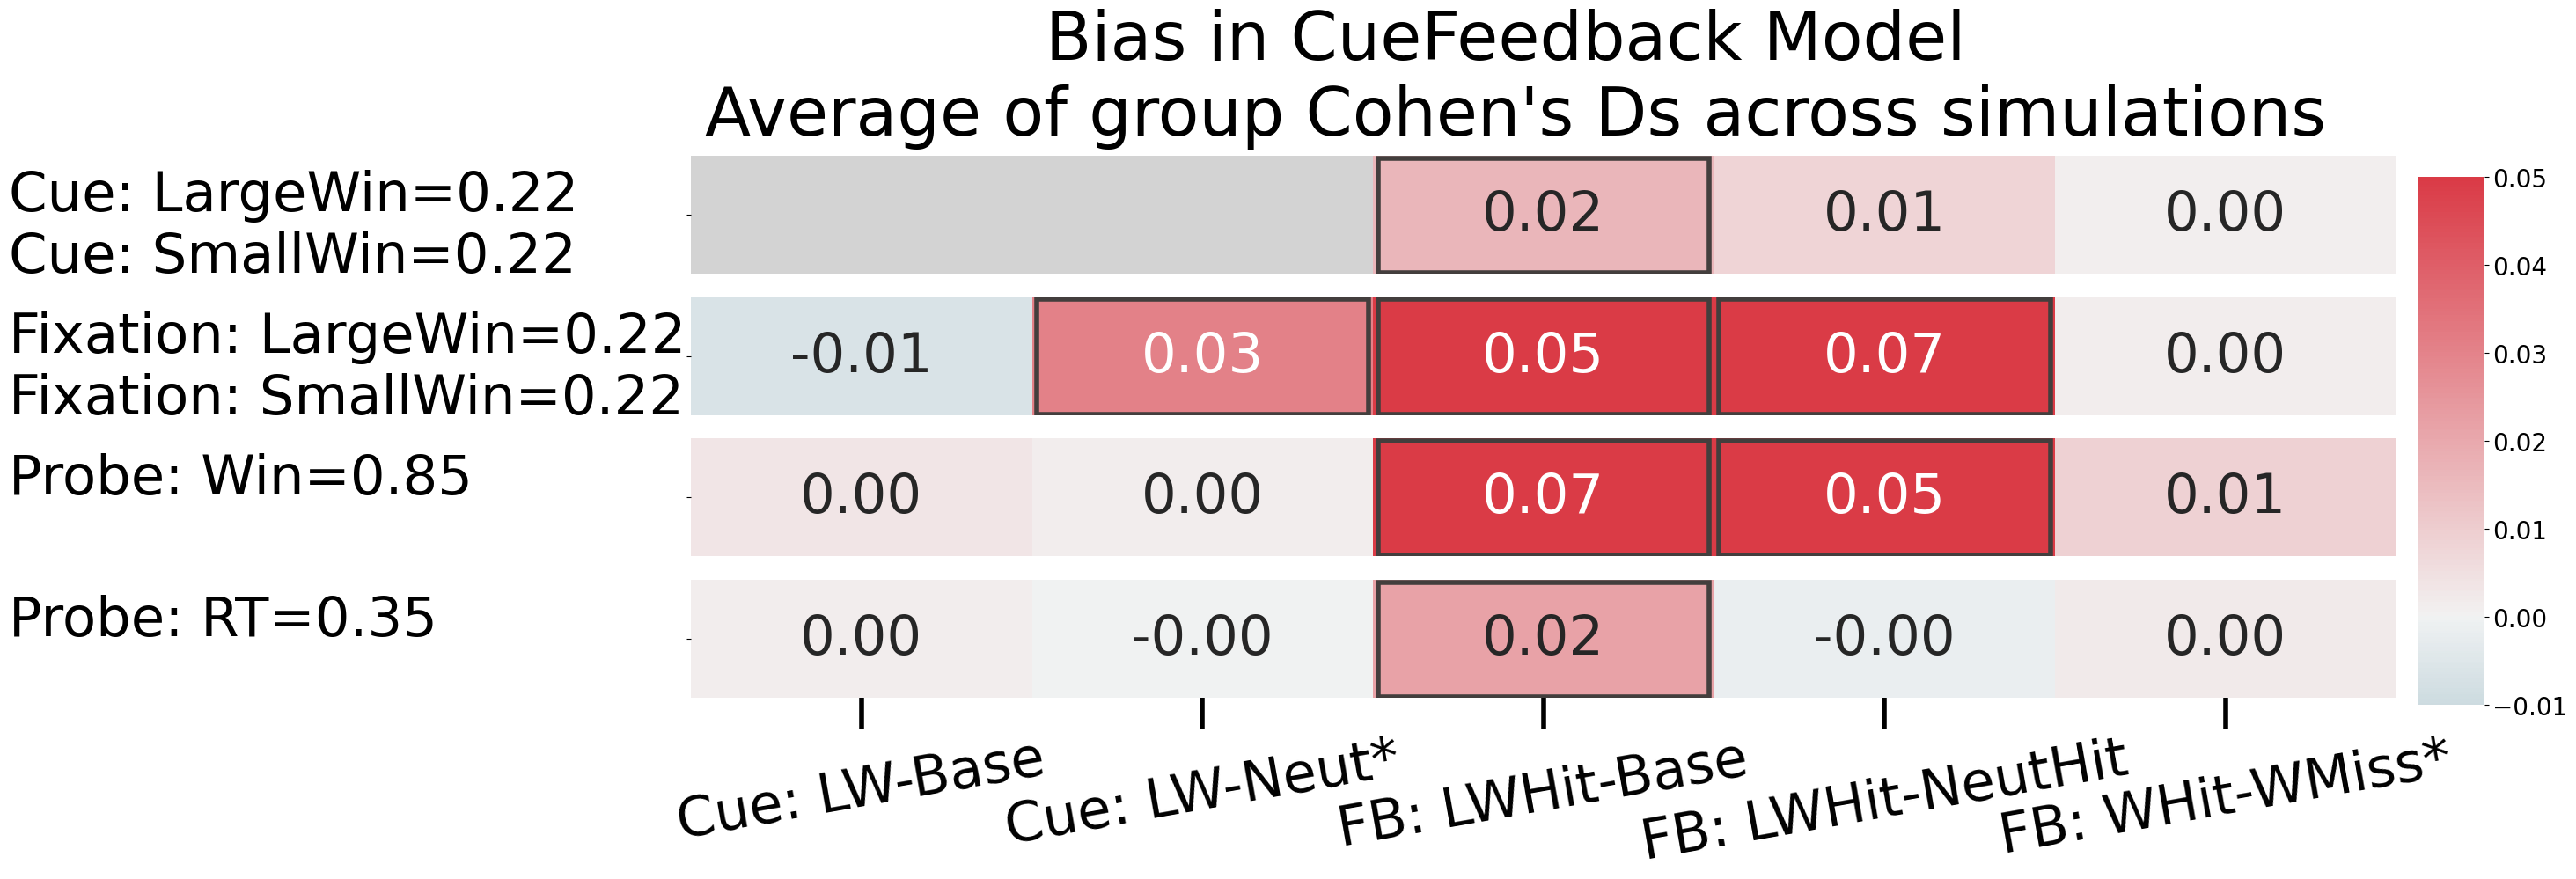

In [130]:
# for poster
from mid_simulations.simulation_plotting import (
    plot_bias_significance_poster,
)

fig_path = f'{figure_output_path}/bias_grid_no_jitter_sig_poster.pdf'

keys_to_drop = ['Null model', 'Feedback: LargeWinHit=0.25, Feedback: SmallWinHit=0.25']
results_filtered_poster = {
    key: results_filtered[key] for key in results_filtered if key not in keys_to_drop
}


plot_bias_significance_poster(
    results_filtered_poster,
    contrasts_only=True,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='CueFeedback',
)

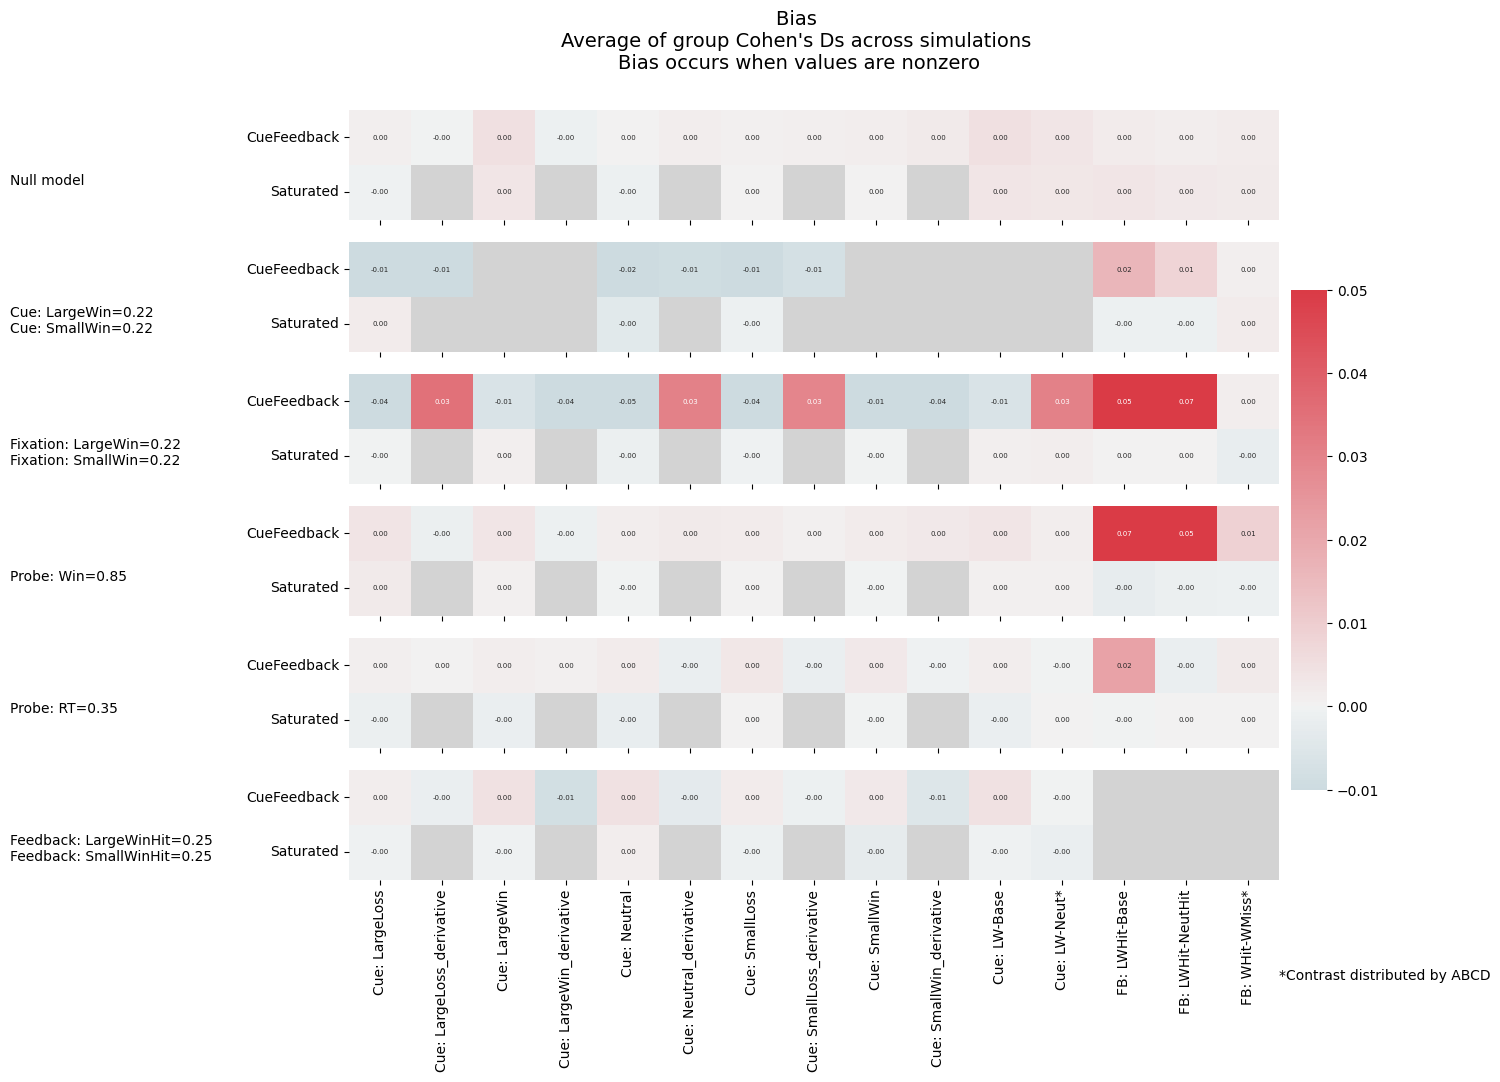

In [14]:
fig_path = f'{figure_output_path}/bias_grid_no_jitter_all.pdf'

plot_bias(
    results_filtered,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='CueFeedback',
)

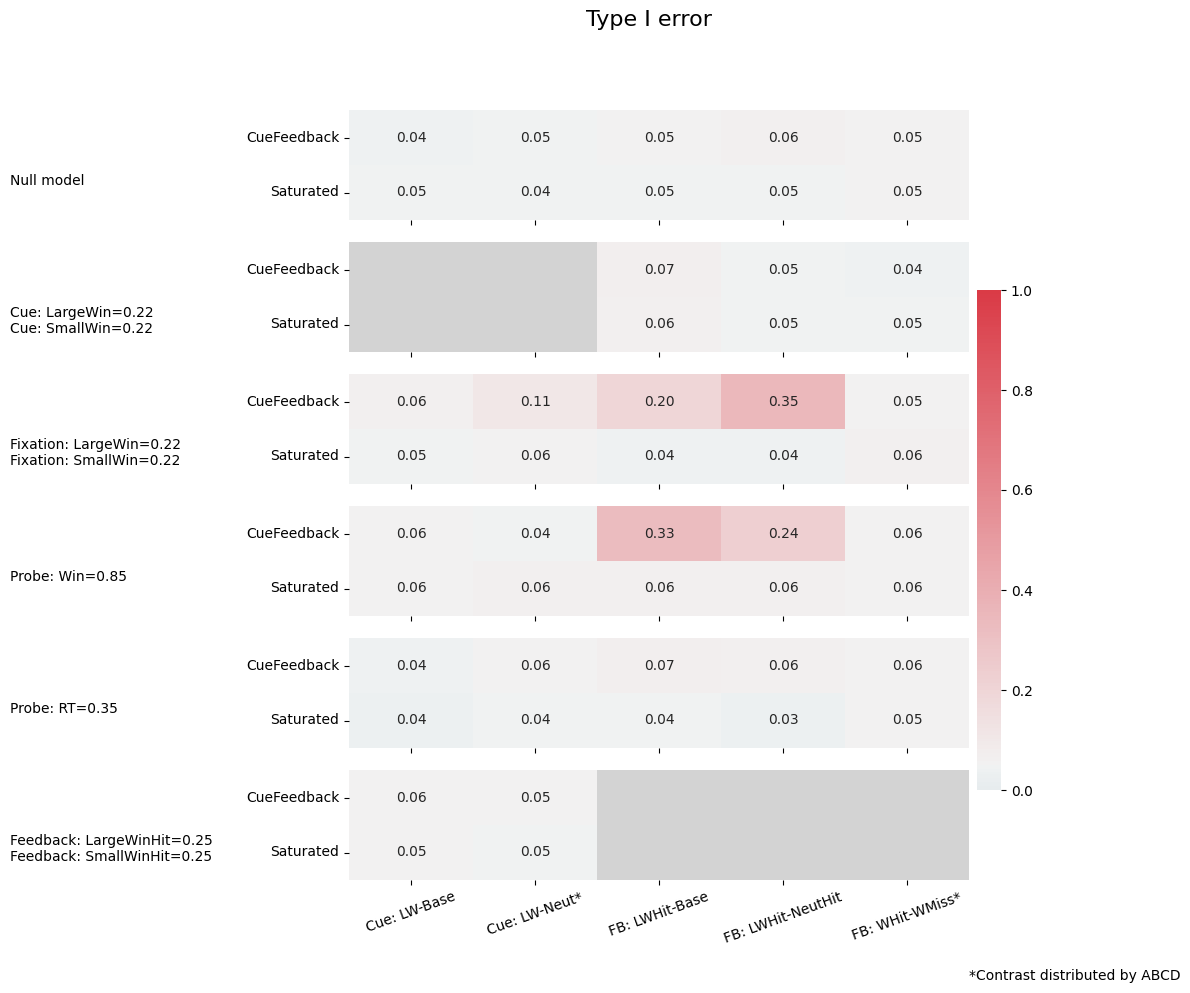

In [15]:
fig_path = f'{figure_output_path}/error_grid_no_jitter_contrasts.pdf'

plot_error_grid(
    results_filtered,
    contrasts_only=True,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='CueFeedback',
)

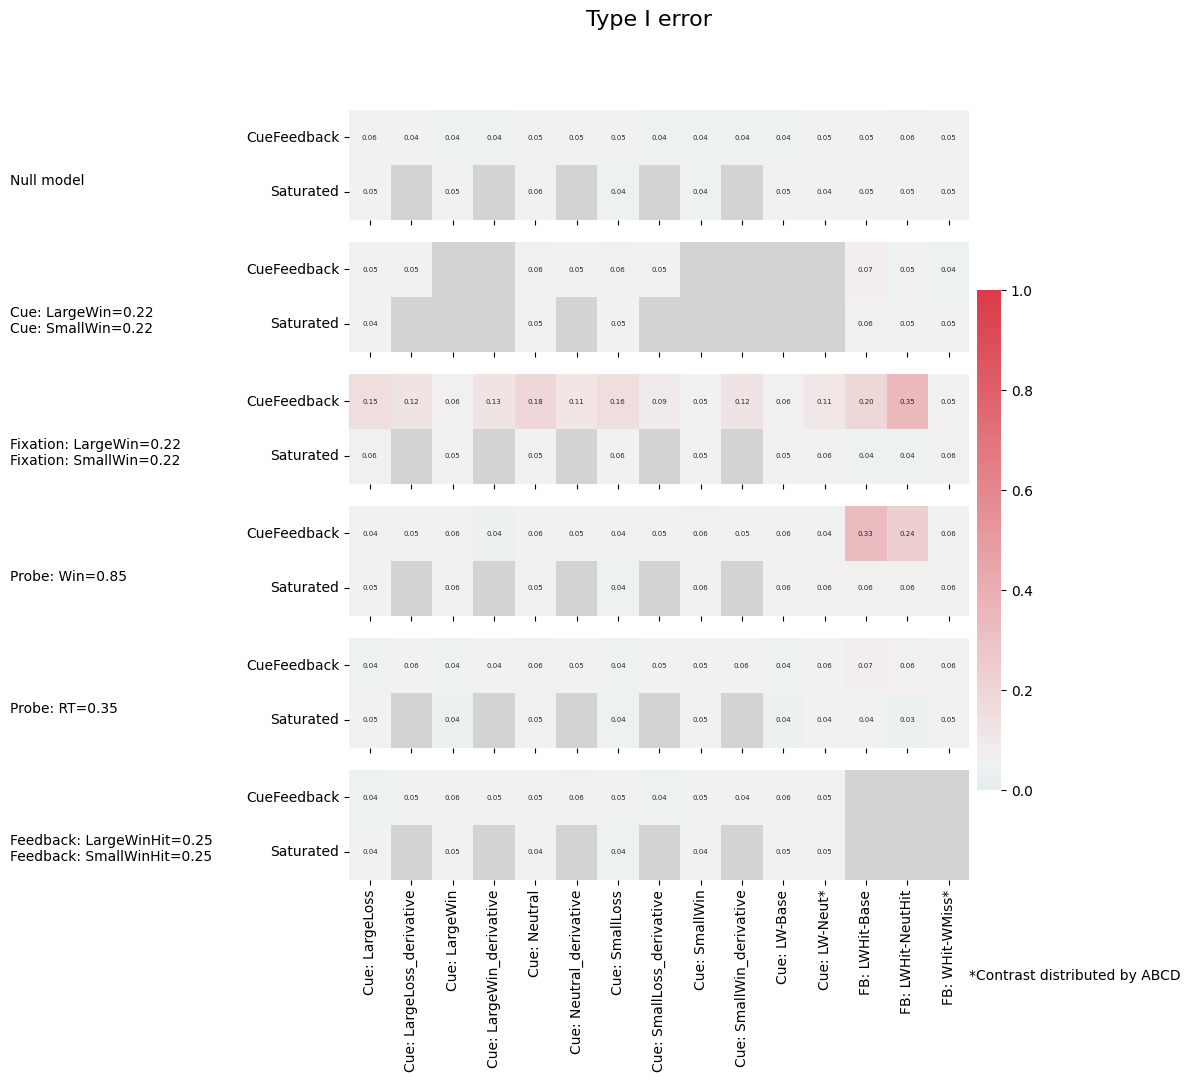

In [16]:
fig_path = f'{figure_output_path}/error_grid_no_jitter_all.pdf'

plot_error_grid(
    results_filtered,
    omit_noderiv=True,
    jitter=False,
    fig_path=fig_path,
    newname_cue_yes_deriv='CueFeedback',
)

## Repeat, but add a jittered ITI


In [17]:
beta_sub_sd = 1.5
noise_sd = 1
nsims = 1000

results_jitter = {}

for beta_dict in beta_dicts:
    print(beta_dict)
    figure_label = make_analysis_label(beta_dict)
    (
        results_jitter[figure_label],
        _,
        desmat_example_jitter,
    ) = sim_group_models_parallel(
        beta_dict,
        noise_sd,
        beta_sub_sd,
        nsims=nsims,
        oversampling=5,
        tr=1,
        jitter=True,
        jitter_iti_min=2,
        jitter_iti_max=5,
        dataset=dataset,
        include_hp_filter=True,
    )

{}
{'Cue: LargeWin': 0.22, 'Cue: SmallWin': 0.22}
{'Fixation: LargeWin': 0.22, 'Fixation: SmallWin': 0.22}
{'Probe: Win': 0.85}
{'Probe: RT': 0.35}
{'Feedback: LargeWinHit': 0.25, 'Feedback: SmallWinHit': 0.25}


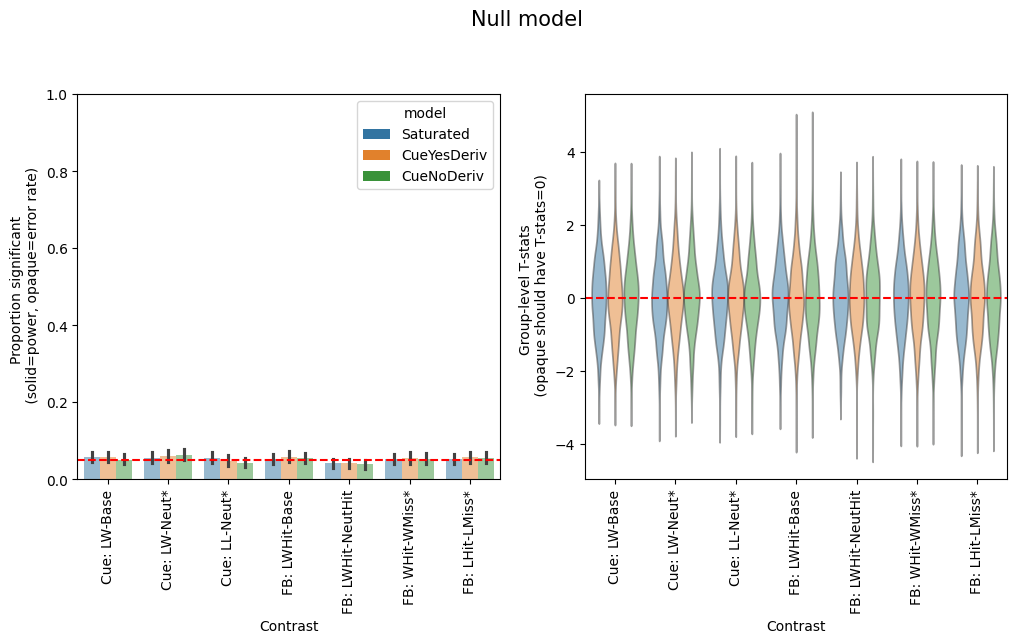

In [18]:
plot_dict_of_results({'Null model': results_jitter['Null model']}, contrasts=True)

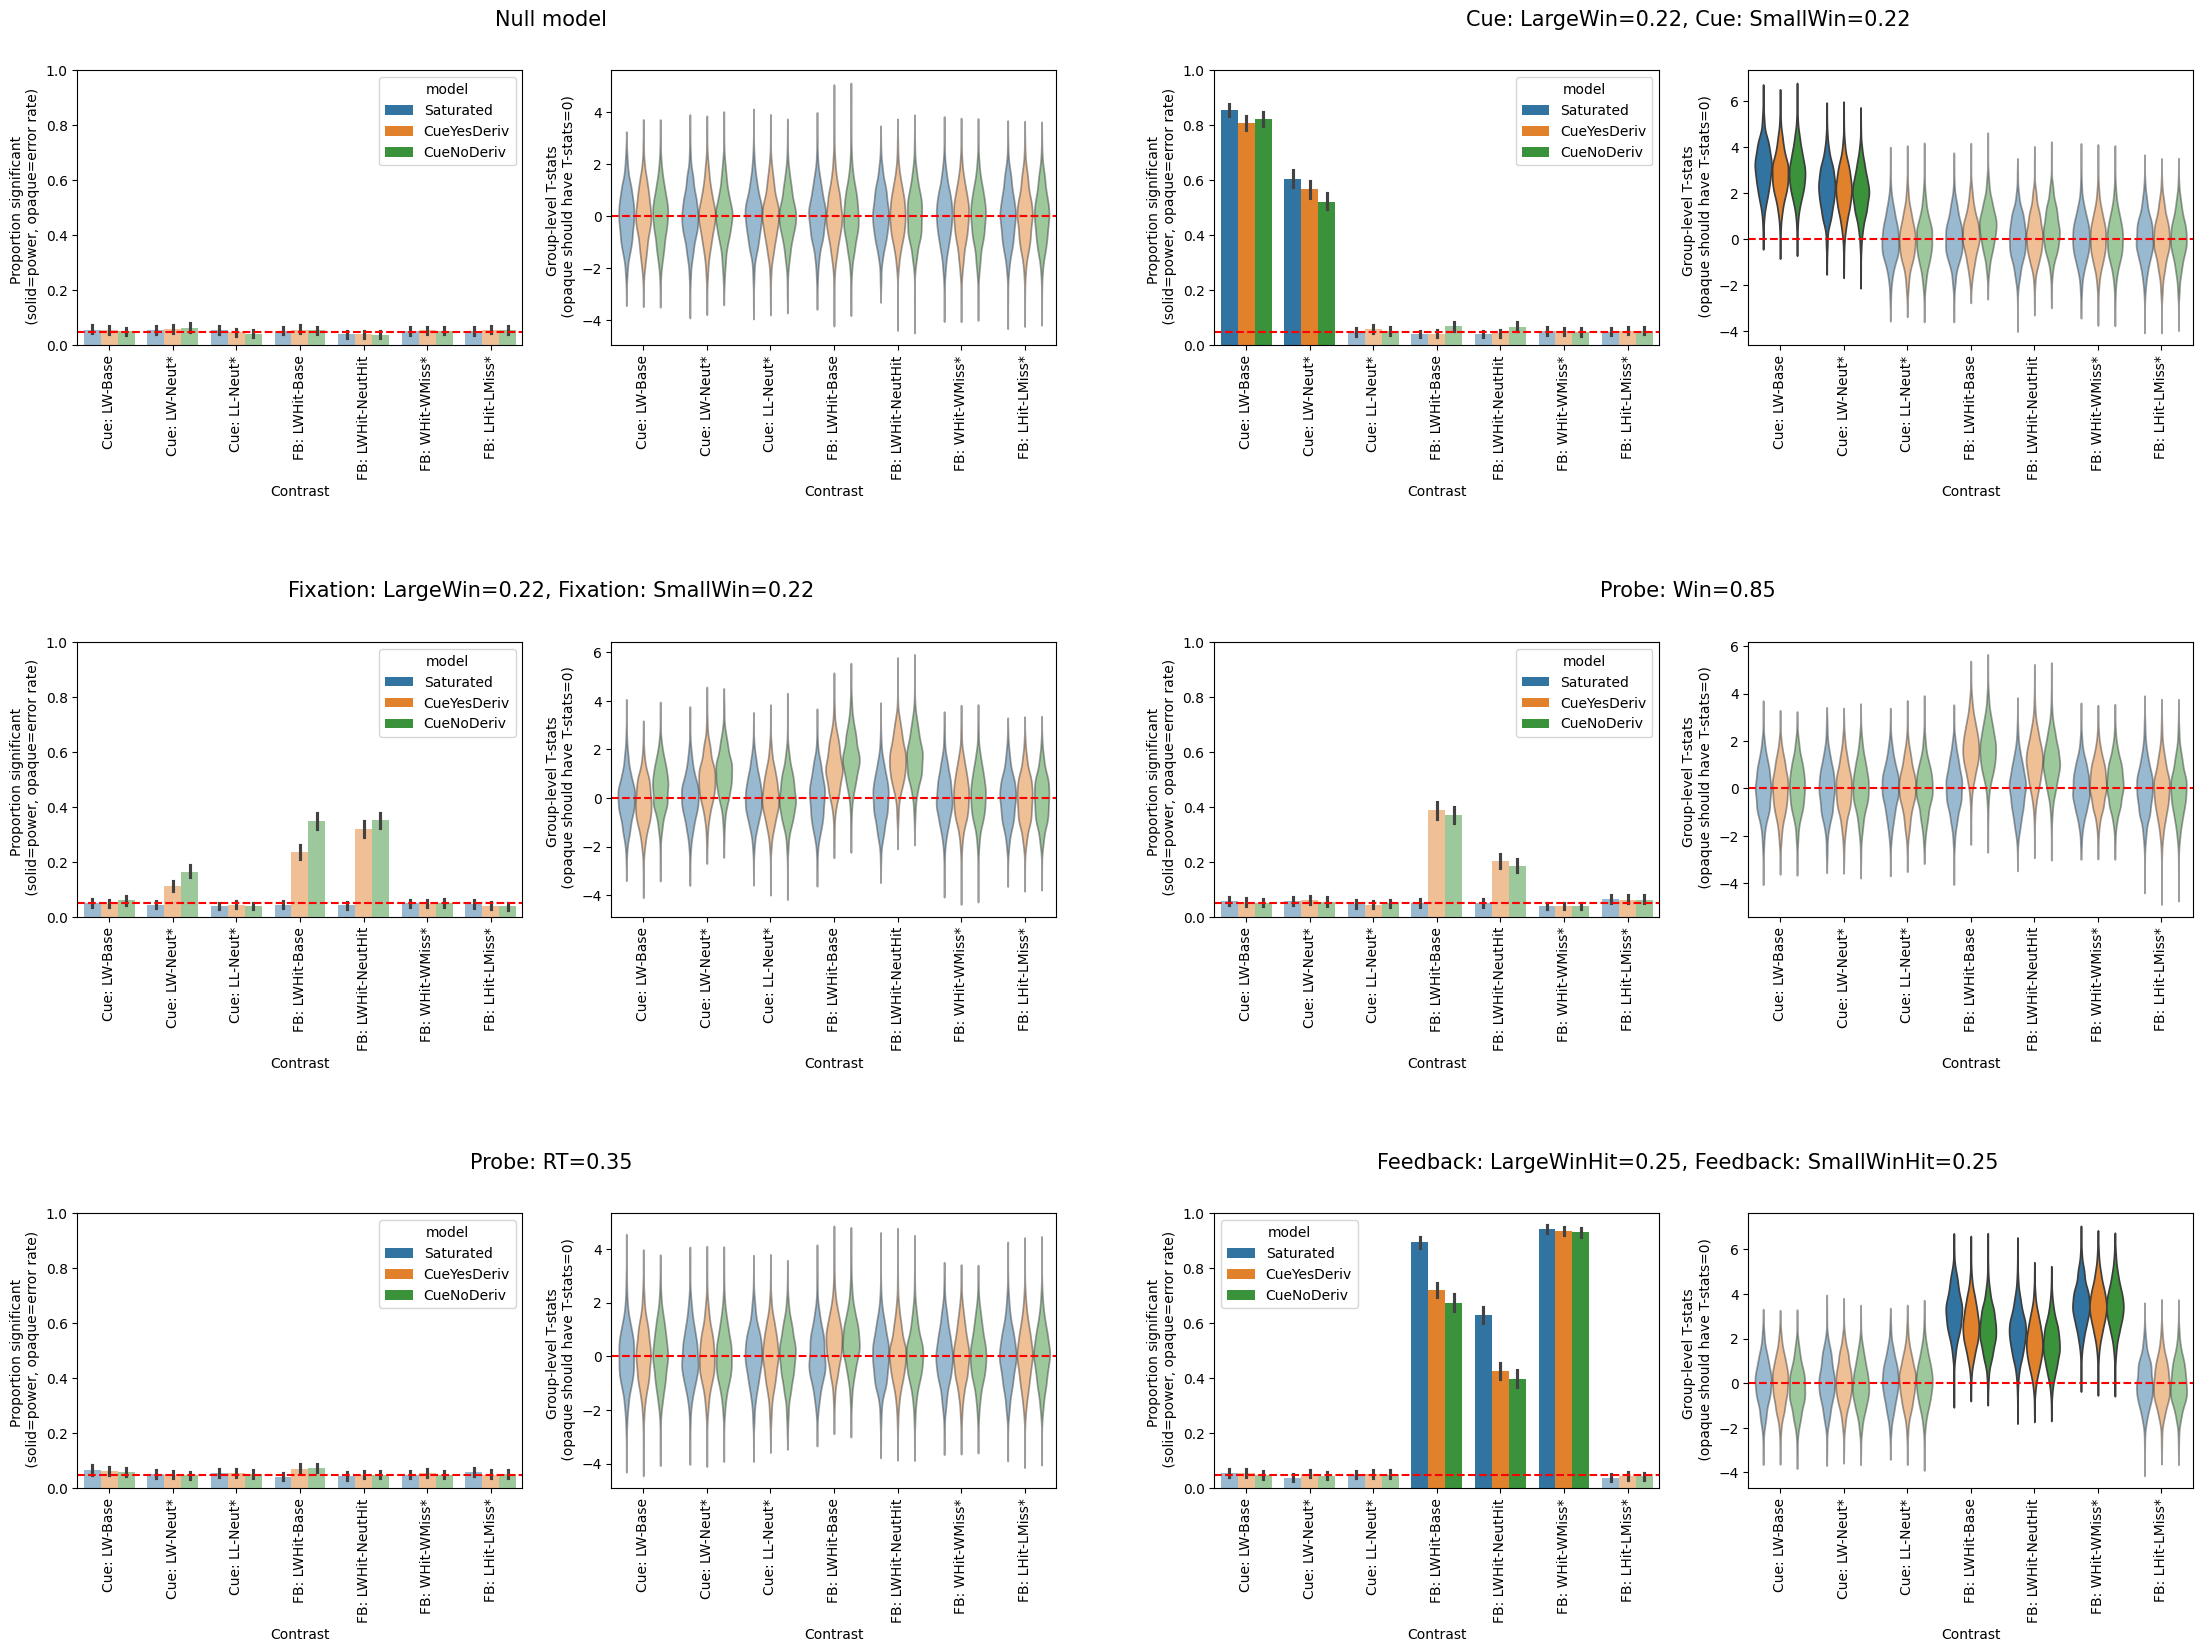

In [19]:
results_jitter_plot = results_jitter.copy()
if len(results_jitter_plot) % 2 != 0:
    results_jitter_plot.pop('Null model')
plot_dict_of_results(results_jitter_plot, contrasts=True)

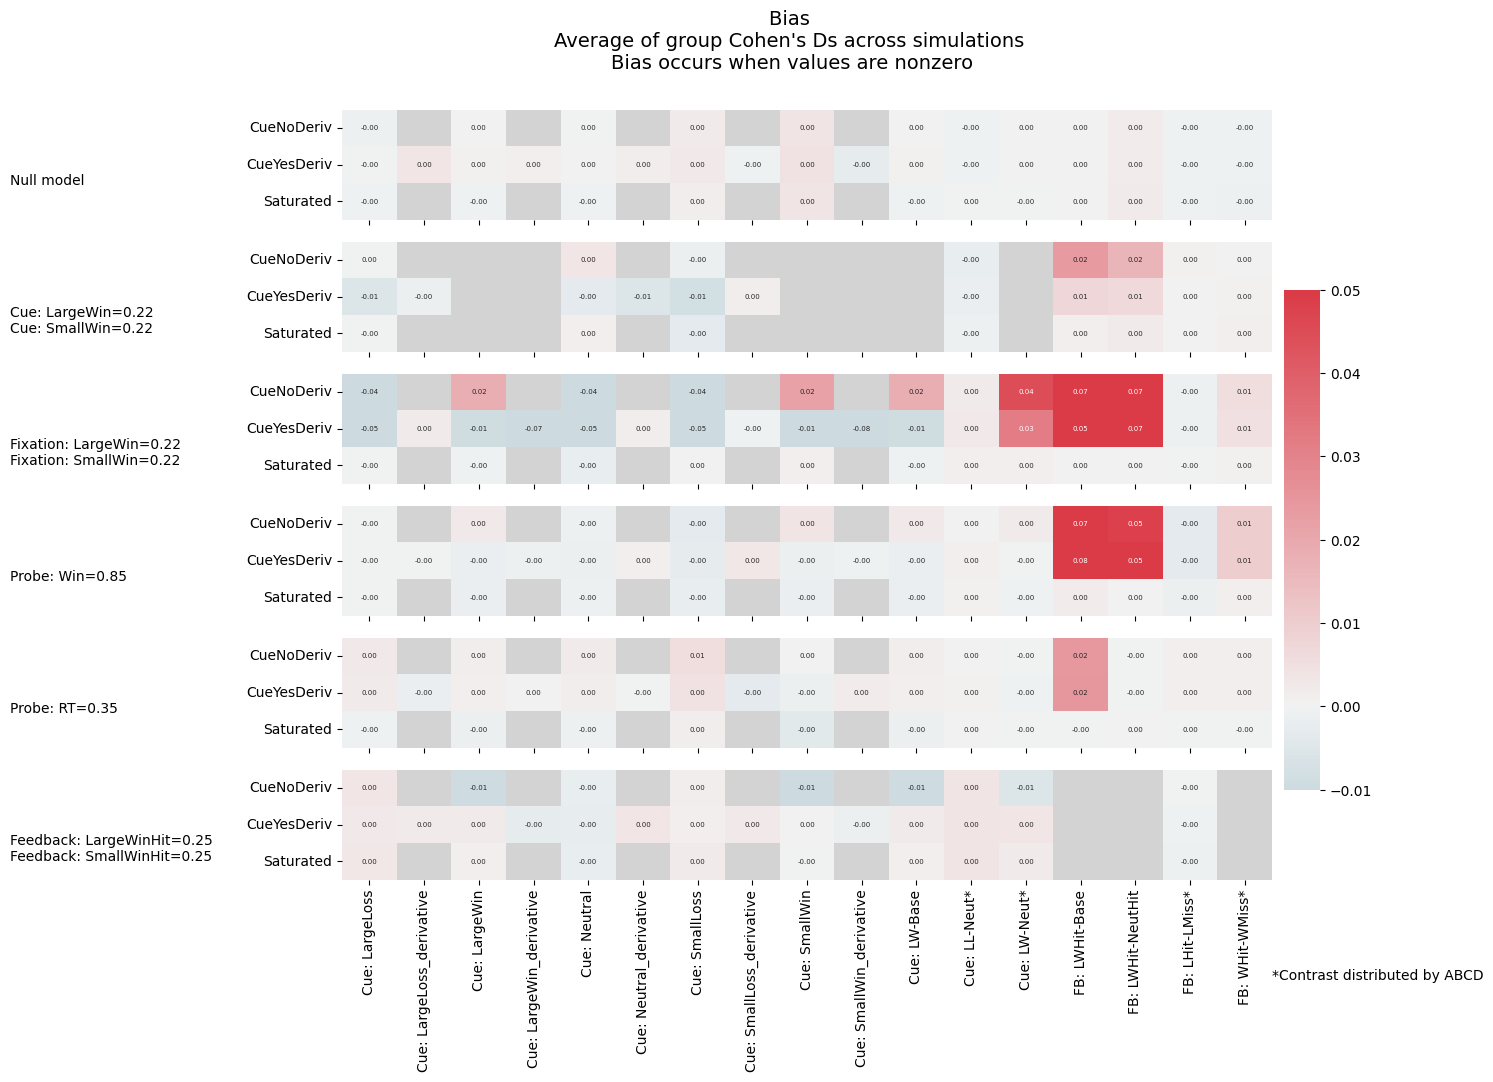

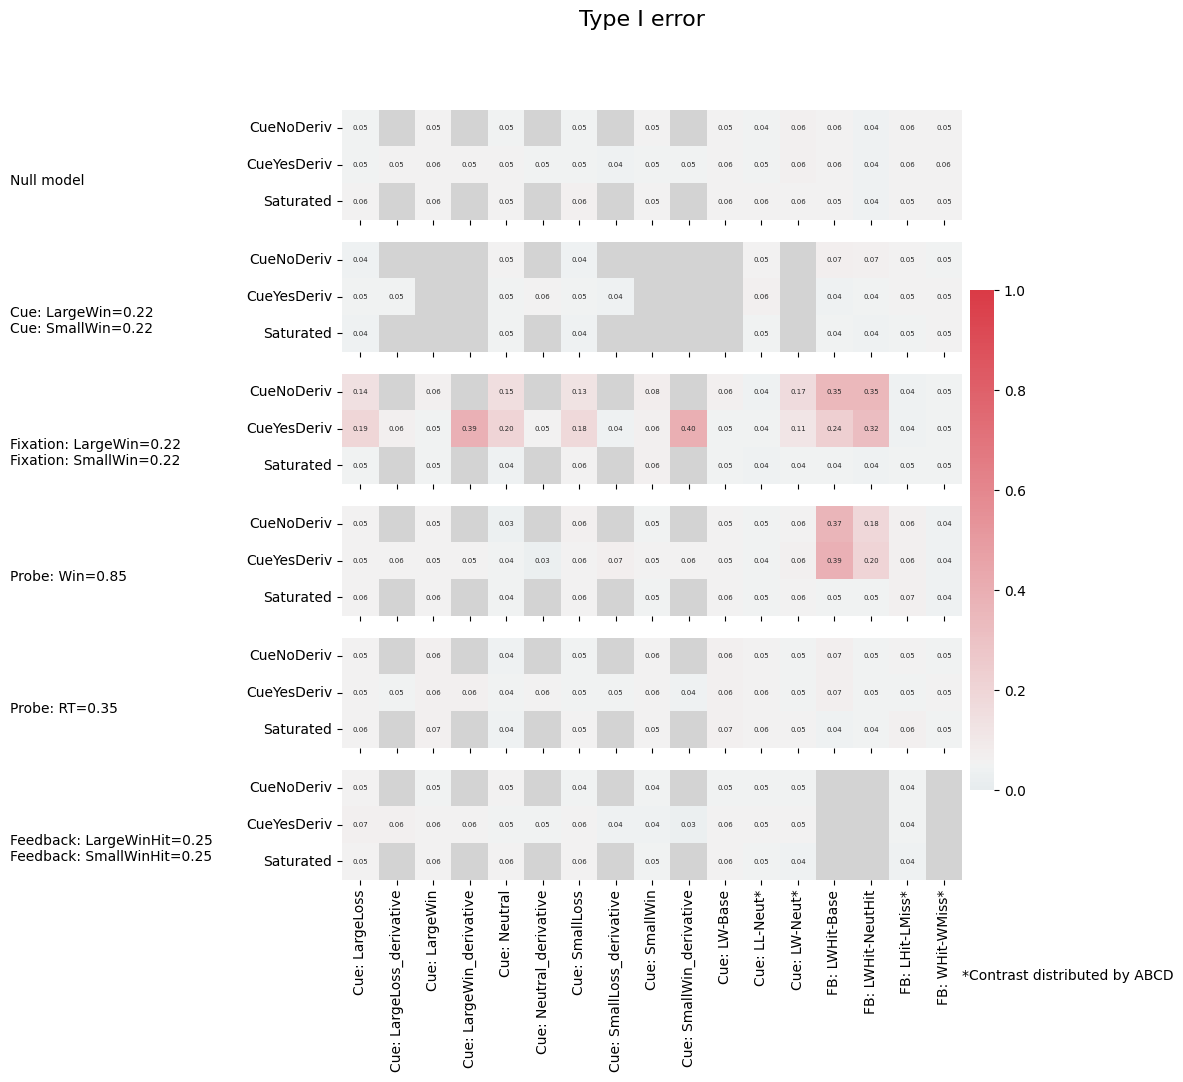

In [20]:
plot_bias(results_jitter)

plot_error_grid(results_jitter)